In [0]:
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
from collections import Counter

In [0]:
import pandas as pd

The columns included in this dataset are:<br>

ID : the numeric ID of the article<br>
TITLE : the headline of the article<br>
URL : the URL of the article<br>
PUBLISHER : the publisher of the article<br>
CATEGORY : the category of the news item; one of: -- b : business -- t : science and technology -- e : entertainment -- m : health<br>
STORY : alphanumeric ID of the news story that the article discusses<br>
HOSTNAME : hostname where the article was posted<br>
TIMESTAMP : approximate timestamp of the article's publication, given in Unix time (seconds since midnight on Jan 1, 1970)<br>

__This dataset contains headlines, URLs, and categories for 422,937 news stories collected by a web aggregator between March 10th, 2014 and August 10th, 2014.__

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link= 'https://drive.google.com/open?id=17Qzcum-jCkHW1t0ykUY9BLnt-5mEuTqz'

In [6]:
fluff, id = link.split('=')
print (id)

17Qzcum-jCkHW1t0ykUY9BLnt-5mEuTqz


In [0]:
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('uci-news-aggregator.csv')

In [0]:
news_data=pd.read_csv('uci-news-aggregator.csv')

In [11]:
news_data.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


__lets see how many unique categories of news are there__

In [0]:
news_data['CATEGORY'].value_counts()

e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

In [0]:
entertainment= (152649/422397)*100
entertainment

36.13875098544734

In [0]:
buisness = (115967/422397)*100
buisness

27.454503701494094

In [0]:
technology = (108344/422397)*100
technology

25.64980338402025

In [0]:
medical = (45639/422397)*100
medical

10.804764238382376

there are total 422,937 articles out of which <br>
1. 36% article is of entertainment category <br>
2. 27% article is of buisness category<br>
3. 25% article is of technology category<br>
4. 10% article is of medical category<br>

__CHECKING FOR NULL VALUES IN DATA__

In [0]:
news_data.isnull().any()

ID           False
TITLE        False
URL          False
PUBLISHER     True
CATEGORY     False
STORY        False
HOSTNAME     False
TIMESTAMP    False
dtype: bool

__AS you can see there is null value in PUBLISHER column so we have to fill/remove the value__

In [0]:
news_data['PUBLISHER'].isnull().value_counts()

False    422417
True          2
Name: PUBLISHER, dtype: int64

In [0]:
news_data = news_data.dropna(how='any',axis=0) 

__why i remove the null value because it will not affect my data if I remove 2 row out of 4lac__

<h1> EXPLORATORY DATA ANALYSIS</h1>

__LETS SEE HOW MANY ARTICLE PUBLISHED PER MONTH__

In [0]:
news_data=news_data.sort_values(by='TIMESTAMP')

In [0]:
news_data['TIMESTAMP'] = pd.to_datetime(news_data['TIMESTAMP'], unit='ms')

In [0]:
news_data[0:1]

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,2014-03-10 16:52:50.698


In [0]:
news_data[-1:]

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
422418,422937,Phoenix boy undergoes surgery to repair throat...,http://www.cbs3springfield.com/story/26368078/...,WSHM-TV,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.cbs3springfield.com,2014-08-28 12:33:11.565


we have data from 10-03-2014 to 28-08-2014 <br>
from march to august approx 6 months

In [0]:
news_data['MONTH'] = news_data['TIMESTAMP'].apply(lambda date: date.month)

In [0]:
news_data['MONTH']=news_data['MONTH'].replace({3: 'MARCH',4 : 'APRIL' , 5 :'MAY',6:'JUNE',7:'JULY',8:'AUGUST'})

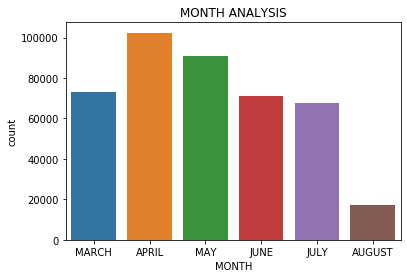

In [0]:
ax = sns.countplot(x="MONTH", data=news_data).set_title('MONTH ANALYSIS')

__AS YOU CAN SEE IN APRIL MONTH MOST OF THE ARTICLE WAS PUBLISHED AFTER APRIL THERE IS SIGNIFICANTLY DECREASE IN THE NO OF ARTICLES__

<h1> CATEGORY </h1>

In [0]:
news_Data1=news_data

In [0]:
news_Data1['CATEGORY']=news_Data1['CATEGORY'].replace({'b': 'BUISNESS', 't': 'TECHNOLOGY' , 'm' :'MEDICAL', 'e':'ENTERTAINMENT'})

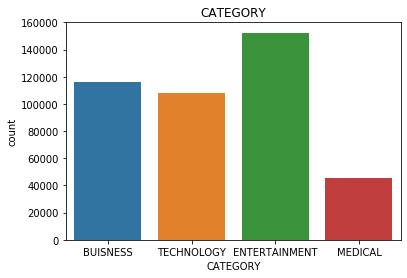

In [0]:
ax = sns.countplot(x="CATEGORY", data=news_Data1).set_title('CATEGORY')

__MOST OF THE CATEGORY IS OF ENTERTAINMENT MAIN REASON CAN BE MOST OF THE SUB CATEGORY LIKE SPORtS , MOVIE and ALL can be Includes in entertainment.__

<h1>PUBLISHER</h1>

__LETS SEE SOME OF THE MOST FAMOUS PUBLISHER BECAUSE THERE ARE MANY PUBLiSHER to Plot GRAPH of all publisher can be messy__

In [0]:
news_data['PUBLISHER'].value_counts()

Reuters                               3902
Huffington Post                       2455
Businessweek                          2395
Contactmusic.com                      2334
Daily Mail                            2254
                                      ... 
InfoToday.com                            1
USPRwire \(press release\)               1
Wicked Local Georgetown                  1
Indian Country Today Media Network       1
RW Freight                               1
Name: PUBLISHER, Length: 10985, dtype: int64

__there are total 10985 publishers of articles__<br>
__LETS PLOT 10 of them__

In [0]:
df_val_counts = pd.DataFrame(news_data['PUBLISHER'].value_counts())

In [0]:
publi = pd.DataFrame(news_data.PUBLISHER.value_counts().reset_index())
publi.columns = ['PUBLISHER', 'count']
publi=publi[0:10]

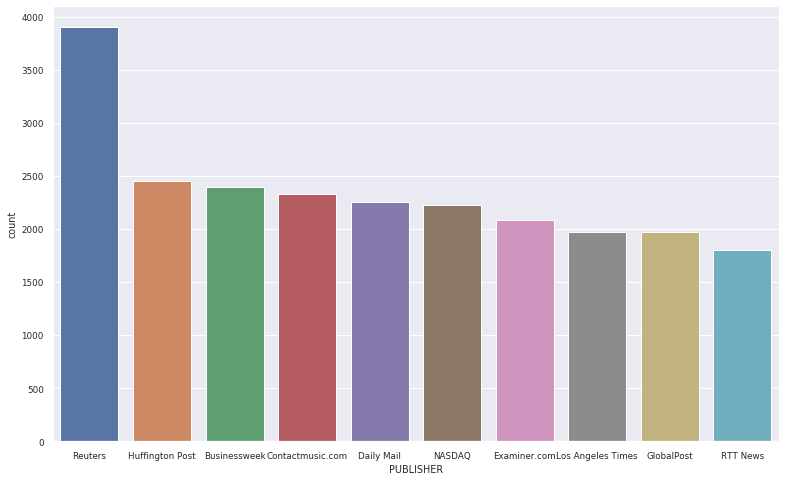

In [0]:
 sns.set_style('whitegrid')
 sns.set(rc={'figure.figsize': (13, 8)}, font_scale=0.8)
 ax = sns.barplot(x="PUBLISHER", y="count", data=publi)

__fron the above plot you can see that Highest Article Publisher is REUTERS__

__AFTER PERFORMING EDA I CAN SAY THAT THE DATASET SHOUld INCludE more CATEGORY LIKE POLITICS AND SPORTS eg WHEN GOVT WORD IS INCLUDED HOW CAN CATEGORY CAN BE DEFINED.__

<h1>WORD CLOUd</h1>


https://blog.goodaudience.com/how-to-generate-a-word-cloud-of-any-shape-in-python-7bce27a55f6e

In [0]:
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import numpy as np
import urllib
import requests
import matplotlib.pyplot as plt

In [0]:
mask = np.array(Image.open(requests.get('http://www.clker.com/cliparts/e/a/c/0/12456403531276059448baroquon_Add_Money.svg.med.png', stream=True).raw))
mask1 = np.array(Image.open(requests.get('http://www.clker.com/cliparts/5/a/8/7/12375609571200265874pitr_Rocket_icon.svg.med.png', stream=True).raw))
mask2 = np.array(Image.open(requests.get('http://www.clker.com/cliparts/8/e/b/8/11949848722015671592musical_note_nicu_bucule_01.svg.med.png', stream=True).raw))
mask3 = np.array(Image.open(requests.get('http://www.clker.com/cliparts/f/c/5/c/1238703067440176098johnny_automatic_lungs.svg.med.png', stream=True).raw))

In [0]:
# create dataframe for each category
b_news = news_data.loc[news_data['CATEGORY'] == 'b'] # business
t_news = news_data.loc[news_data['CATEGORY'] == 't'] # science and technology
e_news = news_data.loc[news_data['CATEGORY'] == 'e'] # entertainment 
m_news = news_data.loc[news_data['CATEGORY'] == 'm'] # health

In [0]:
# convert news titles to usable strings for the word clouds
b_title = b_news['TITLE'].to_string()
t_title = t_news['TITLE'].to_string()
e_title = e_news['TITLE'].to_string()
m_title = m_news['TITLE'].to_string()

In [0]:
def generate_wordcloud(words, mask):
    word_cloud = WordCloud(width = 512, height = 512, background_color='white', stopwords=STOPWORDS, mask=mask).generate(words)
    return word_cloud

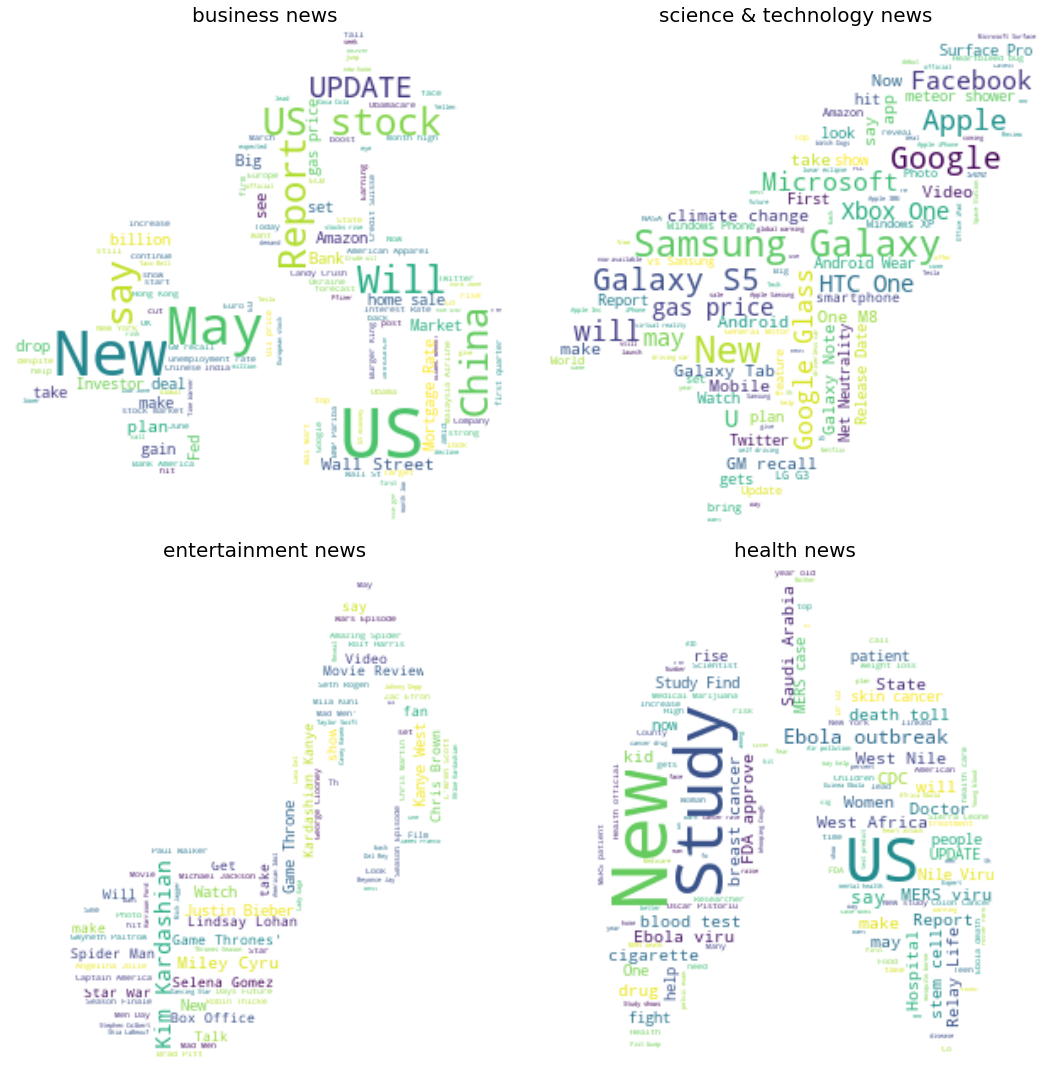

In [0]:
fig = plt.figure(figsize=(15,15))

# setting stop-words, so words like "the" and "it" are ignored
stopwords = set(STOPWORDS)

# business news cloud
ax1 = fig.add_subplot(221)
b_wordcloud = generate_wordcloud(b_title,mask)
ax1.imshow(b_wordcloud, interpolation='bilinear')
ax1.set_title('business news', size=20)
ax1.axis('off')

# science and technology news cloud
ax2 = fig.add_subplot(222)
t_wordcloud = generate_wordcloud(t_title,mask1)
ax2.imshow(t_wordcloud, interpolation='bilinear')
ax2.set_title('science & technology news', size=20)
ax2.axis('off')

# entertainment news cloud
ax3 = fig.add_subplot(223)
e_wordcloud = generate_wordcloud(e_title,mask2)
ax3.imshow(e_wordcloud, interpolation='bilinear')
ax3.set_title('entertainment news', size=20)
ax3.axis('off')

# health news cloud
ax4 = fig.add_subplot(224)
m_wordcloud = generate_wordcloud(m_title,mask3)
ax4.imshow(m_wordcloud, interpolation='bilinear')
ax4.set_title('health news', size=20)
ax4.axis('off')

fig.tight_layout()

<br>you can see the most occuring words in each category</br>

<h1> LETS PREDICT</h1>

__BEFORE PREDICTING LETS PREPROCESS DATA__

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

__PREPROCESSING IS A MUST STEP EVERYONE SHOULD DO BECAUSE ANY SPECIAL CHARACTER, REPEATED WORDS CAN AFFECT YOUR MODEL__

In [0]:
#what i am doing can be understand from below example

In [0]:
sent = decontracted(news_data['TITLE'].values[20000])
print(sent)
print("="*50)

Miley Cyrus Inks Inner Lip with a Sad Kitten: What Does this Mean?


In [0]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

The Flaming Lips To Record 'Sgt. Pepper is' Cover Record With Miley Cyrus, MGMT


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

The Flaming Lips To Record Sgt Pepper is Cover Record With Miley Cyrus MGMT


In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(news_data['TITLE'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_title.append(sent.lower().strip())

100%|██████████| 422417/422417 [00:12<00:00, 34445.53it/s]


In [0]:
news_data['clean_titles'] = preprocessed_title

__SPLIT THE DATA__

In [0]:
y=news_data['CATEGORY']
news_data.drop(['CATEGORY','URL','PUBLISHER','STORY','HOSTNAME','TIMESTAMP','MONTH'] , axis=1, inplace = True)

In [0]:
X=news_data

In [0]:
X.head()

,ID,TITLE,clean_titles
0,1,"Fed official says weak data caused by weather,...",fed official says weak data caused weather not...
1,2,Fed's Charles Plosser sees high bar for change...,fed charles plosser sees high bar change pace ...
2,3,US open: Stocks fall after Fed official hints ...,us open stocks fall fed official hints acceler...
3,4,"Fed risks falling 'behind the curve', Charles ...",fed risks falling behind curve charles plosser...
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,fed plosser nasty weather has curbed job growth


__FEATURE ENGINEERING FOR INCREASING ACCURACCY IN TEXT CLASSIFICATION__

In [0]:
#Now we have processed and pre-processed text in our dataframe. Lets start making features from
#the above data.

#Initially we will create the basic features: 1 - Count of words in a statement(Vocab size), 
#2 - Count of characters in a statement & 3 - Diversity_score.

#In most of the cases above 3 features display the variations between writing styles of the authors.

#Feature 1 - Length of the input OR count of the words in the statement(Vocab size).
X['WORD_COUNT']= X["TITLE"].apply(lambda x: len(str(x).split()))

#Feature 2 - Count of characters in a statement
X['CHARACTER_COUNT'] = X["TITLE"].apply(lambda x: len(str(x)))

#Feature 3-Diversity_score i.e. Average length of words used in statement
X['AVERAGE_LENGTH'] = X['CHARACTER_COUNT'] / X['WORD_COUNT']
X.head(5)

,ID,TITLE,clean_titles,WORD_COUNT,CHARACTER_COUNT,AVERAGE_LENGTH
0,1,"Fed official says weak data caused by weather,...",fed official says weak data caused weather not...,12,68,5.666667
1,2,Fed's Charles Plosser sees high bar for change...,fed charles plosser sees high bar change pace ...,12,66,5.500000
2,3,US open: Stocks fall after Fed official hints ...,us open stocks fall fed official hints acceler...,11,69,6.272727
3,4,"Fed risks falling 'behind the curve', Charles ...",fed risks falling behind curve charles plosser...,9,58,6.444444
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,fed plosser nasty weather has curbed job growth,8,50,6.250000


In [0]:
#Feature-7: Count of punctuations in the input.
X['PUNCTUATION_COUNT'] = X['TITLE'].apply(lambda x: len([w for w in str(x) if w in string.punctuation]) )

In [0]:
X.head()

,ID,TITLE,clean_titles,WORD_COUNT,CHARACTER_COUNT,AVERAGE_LENGTH,PUNCTUATION_COUNT
0,1,"Fed official says weak data caused by weather,...",fed official says weak data caused weather not...,12,68,5.666667,1
1,2,Fed's Charles Plosser sees high bar for change...,fed charles plosser sees high bar change pace ...,12,66,5.500000,1
2,3,US open: Stocks fall after Fed official hints ...,us open stocks fall fed official hints acceler...,11,69,6.272727,1
3,4,"Fed risks falling 'behind the curve', Charles ...",fed risks falling behind curve charles plosser...,9,58,6.444444,3
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,fed plosser nasty weather has curbed job growth,8,50,6.250000,2


In [0]:
from textblob import TextBlob

In [0]:
# functions to get polatiy and subjectivity of text using the module textblob
def get_polarity(text):
    try:
        textblob = TextBlob(unicode(text, 'utf-8'))
        pol = textblob.sentiment.polarity
    except:
        pol = 0.0
    return pol

def get_subjectivity(text):
    try:
        textblob = TextBlob(unicode(text, 'utf-8'))
        subj = textblob.sentiment.subjectivity
    except:
        subj = 0.0
    return subj


# change df_small to df to create these features on complete dataframe
X['polarity'] = X['TITLE'].apply(get_polarity)
X['subjectivity'] = X['TITLE'].apply(get_subjectivity)

In [0]:
X.tail()

,ID,TITLE,clean_titles,WORD_COUNT,CHARACTER_COUNT,AVERAGE_LENGTH,PUNCTUATION_COUNT,polarity,subjectivity
422414,422933,Surgeons to remove 4-year-old's rib to rebuild...,surgeons remove 4 year old rib rebuild damaged...,13,74,5.692308,7,0.0,0.0
422415,422934,Boy to have surgery on esophagus after battery...,boy surgery esophagus battery burns hole throat,12,67,5.583333,0,0.0,0.0
422416,422935,Child who swallowed battery to have reconstruc...,child swallowed battery reconstructive surgery...,11,77,7.000000,3,0.0,0.0
422417,422936,Phoenix boy undergoes surgery to repair throat...,phoenix boy undergoes surgery repair throat da...,12,74,6.166667,1,0.0,0.0
422418,422937,Phoenix boy undergoes surgery to repair throat...,phoenix boy undergoes surgery repair throat da...,13,78,6.000000,4,0.0,0.0


In [0]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
all_text_without_sw = ''
for i in news_data.itertuples():
    all_text_without_sw = all_text_without_sw +  str(i.TITLE)

In [0]:
from nltk.tokenize import word_tokenize

In [0]:
tokenized_all_text = word_tokenize(all_text_without_sw) #tokenize the text

In [0]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:
list_of_tagged_words = nltk.pos_tag(tokenized_all_text) #adding POS Tags to tokenized words

In [0]:
list_of_tagged_words[0:5]

[('Fed', 'NNP'),
 ('official', 'NN'),
 ('says', 'VBZ'),
 ('weak', 'JJ'),
 ('data', 'NNS')]

In [0]:
set_pos  = (set(list_of_tagged_words)) # set of POS tags & words

In [0]:
nouns = ['NN','NNS','NNP','NNPS'] #POS tags of nouns

In [0]:
list_of_words = set(map(lambda tuple_2 : tuple_2[0], filter(lambda tuple_2 : tuple_2[1] in  nouns, set_pos)))

In [0]:
X['NOUN'] = X['TITLE'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]) )

In [0]:
pronouns = ['PRP','PRP$','WP','WP$'] # POS tags of pronouns

In [0]:
list_of_words = set(map(lambda tuple_2 : tuple_2[0], filter(lambda tuple_2 : tuple_2[1] in  pronouns, set_pos)))

In [0]:
X['PRONOUN_COUNT'] = X['TITLE'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]) )

In [0]:
verbs = ['VB','VBD','VBG','VBN','VBP','VBZ'] #POS tags of verbs

In [0]:
list_of_words = set(map(lambda tuple_2 : tuple_2[0], filter(lambda tuple_2 : tuple_2[1] in  verbs, set_pos)))

In [0]:
X['VERBS_COUNT'] = X['TITLE'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]) )

In [0]:
adverbs = ['RB','RBR','RBS','WRB'] #POS tags of adverbs

In [0]:
list_of_words = set(map(lambda tuple_2 : tuple_2[0], filter(lambda tuple_2 : tuple_2[1] in  adverbs, set_pos)))

In [0]:
X['ADVERBS_COUNT'] = X['TITLE'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]) )

In [0]:
adjectives = ['JJ','JJR','JJS'] #POS tags of adjectives

In [0]:
list_of_words = set(map(lambda tuple_2 : tuple_2[0], filter(lambda tuple_2 : tuple_2[1] in  adjectives, set_pos)))

In [0]:
X['ADJECTTIVE_COUNT'] = X['TITLE'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]) )

In [0]:
X.head()

,ID,TITLE,clean_titles,WORD_COUNT,CHARACTER_COUNT,AVERAGE_LENGTH,PUNCTUATION_COUNT,polarity,subjectivity,NOUN,PRONOUN_COUNT,VERBS_COUNT,ADVERBS_COUNT,ADJECTTIVE_COUNT
0,1,"Fed official says weak data caused by weather,...",fed official says weak data caused weather not...,12,68,5.666667,1,0.0,0.0,5,0,7,2,6
1,2,Fed's Charles Plosser sees high bar for change...,fed charles plosser sees high bar change pace ...,12,66,5.500000,1,0.0,0.0,5,0,5,1,3
2,3,US open: Stocks fall after Fed official hints ...,us open stocks fall fed official hints acceler...,11,69,6.272727,1,0.0,0.0,5,1,6,1,4
3,4,"Fed risks falling 'behind the curve', Charles ...",fed risks falling behind curve charles plosser...,9,58,6.444444,3,0.0,0.0,2,0,4,0,1
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,fed plosser nasty weather has curbed job growth,8,50,6.250000,2,0.0,0.0,3,1,3,1,2


AS WE ARE HAVING FOUR CATEGORY SO WE HAVE TO USE LABEL ENCODER FOR CATEGORY

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
# Create numerical labels.
#I have to do this because my data label is not binary(0/1) so we have to use label encoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [0]:
X_train.head()

,ID,TITLE,clean_titles,WORD_COUNT,CHARACTER_COUNT,AVERAGE_LENGTH,PUNCTUATION_COUNT,polarity,subjectivity,NOUN,PRONOUN_COUNT,VERBS_COUNT,ADVERBS_COUNT,ADJECTTIVE_COUNT
158987,159323,Microsoft Earnings: What to Watch,microsoft earnings what watch,5,33,6.600000,1,0.0,0.0,1,1,1,0,2
207967,208403,"US STOCKS-Futures point to higher open, S&P 50...",us stocks futures point higher open s p 500 ne...,10,59,5.900000,3,0.0,0.0,3,1,3,3,4
163658,163994,NH postal workers to rally against Staples pos...,nh postal workers rally staples postal counters,9,58,6.444444,0,0.0,0.0,3,0,2,1,2
57542,57543,LG G2 KitKat update rolling out to Rogers and ...,lg g2 kitkat update rolling rogers bell custom...,13,70,5.384615,0,0.0,0.0,6,0,2,1,1
360304,360764,Megan Fox Admits That She Bullies Anyone Who D...,megan fox admits that she bullies anyone who d...,13,68,5.230769,0,0.0,0.0,5,3,4,1,1


__PRECISION AND RECALL__

__MAKE DATA MODEL READY ENCODING TITLE__

__BAG OF WORDS__

__WHAT BAG OF WORD DOES IS IT COUNT THE NO OF WORDS IN PARTICULAR SENTENCE AND PLACE THE COUNT IN ARRAY eg:__<br>

It was the best of times,<br>
it was the worst of times,<br>
it was the age of wisdom,<br>
it was the age of foolishness<br>

"it was the worst of times" = [1, 1, 1, 0, 1, 1, 1, 0, 0, 0]<br>
"it was the age of wisdom" = [1, 1, 1, 0, 1, 0, 0, 1, 1, 0]<br>
"it was the age of foolishness" = [1, 1, 1, 0, 1, 0, 0, 1, 0, 1]<br>

for full understanding visit<br>
https://machinelearningmastery.com/gentle-introduction-bag-words-model/

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizerb = CountVectorizer(max_features=5000)
vectorizerb.fit(X_train['clean_titles'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_bow = vectorizerb.transform(X_train['clean_titles'].values)
X_cv_title_bow = vectorizerb.transform(X_cv['clean_titles'].values)
X_test_title_bow = vectorizerb.transform(X_test['clean_titles'].values)

print("After vectorizations")
print(X_train_title_bow.shape, y_train.shape)
print(X_cv_title_bow.shape, y_cv.shape)
print(X_test_title_bow.shape, y_test.shape)
print("="*100)

After vectorizations
(189622, 5000) (189622,)
(93397, 5000) (93397,)
(139398, 5000) (139398,)


__TFIDF__

Term Frequency: This summarizes how often a given word appears within a document.<br>
Inverse Document Frequency: This downscales words that appear a lot across documents.<br>
https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tf = TfidfVectorizer(min_df=5)
vectorizer_tf.fit(X_train['clean_titles'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_tfidf = vectorizer_tf.transform(X_train['clean_titles'].values)
X_cv_title_tfidf = vectorizer_tf.transform(X_cv['clean_titles'].values)
X_test_title_tfidf = vectorizer_tf.transform(X_test['clean_titles'].values)

print(X_train_title_tfidf.shape)
print(X_cv_title_tfidf.shape)
print(X_test_title_tfidf.shape)

(189622, 16998)
(93397, 16998)
(139398, 16998)


__LETS NORMALiZE THE DATA__

In [0]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead:
# array=[105.22 215.96 96.01 ... 368.98 80.53 709.67].
# Reshape your data either using
# array.reshape(-1, 1) if your data has a single feature
# array.reshape(1, -1) if it contains a single sample.
normalizer.fit(X_train['WORD_COUNT'].values.reshape(1,-1))
X_train_wc_norm = normalizer.transform(X_train['WORD_COUNT'].values.reshape(1,-1))
X_cv_wc_norm = normalizer.transform(X_cv['WORD_COUNT'].values.reshape(1,-1))
X_test_wc_norm = normalizer.transform(X_test['WORD_COUNT'].values.reshape(1,-1))
print("After vectorizations")
print(X_train_wc_norm.shape, y_train.shape)
print(X_cv_wc_norm.shape, y_cv.shape)
print(X_test_wc_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 189622) (189622,)
(1, 93397) (93397,)
(1, 139398) (139398,)


In [0]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# this will rise an error Expected 2D array, got 1D array instead:
# array=[105.22 215.96 96.01 ... 368.98 80.53 709.67].
# Reshape your data either using
# array.reshape(-1, 1) if your data has a single feature
# array.reshape(1, -1) if it contains a single sample.
normalizer.fit(X_train['CHARACTER_COUNT'].values.reshape(1,-1))
X_train_cc_norm = normalizer.transform(X_train['CHARACTER_COUNT'].values.reshape(1,-1))
X_cv_cc_norm = normalizer.transform(X_cv['CHARACTER_COUNT'].values.reshape(1,-1))
X_test_cc_norm = normalizer.transform(X_test['CHARACTER_COUNT'].values.reshape(1,-1))
print("After vectorizations")
print(X_train_cc_norm.shape, y_train.shape)
print(X_cv_cc_norm.shape, y_cv.shape)
print(X_test_cc_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 189622) (189622,)
(1, 93397) (93397,)
(1, 139398) (139398,)


In [0]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead:
# array=[105.22 215.96 96.01 ... 368.98 80.53 709.67].
# Reshape your data either using
# array.reshape(-1, 1) if your data has a single feature
# array.reshape(1, -1) if it contains a single sample.
normalizer.fit(X_train['AVERAGE_LENGTH'].values.reshape(1,-1))
X_train_ag_norm = normalizer.transform(X_train['AVERAGE_LENGTH'].values.reshape(1,-1))
X_cv_ag_norm = normalizer.transform(X_cv['AVERAGE_LENGTH'].values.reshape(1,-1))
X_test_ag_norm = normalizer.transform(X_test['AVERAGE_LENGTH'].values.reshape(1,-1))
print("After vectorizations")
print(X_train_ag_norm.shape, y_train.shape)
print(X_cv_ag_norm.shape, y_cv.shape)
print(X_test_ag_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 189622) (189622,)
(1, 93397) (93397,)
(1, 139398) (139398,)


In [0]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead:
# array=[105.22 215.96 96.01 ... 368.98 80.53 709.67].
# Reshape your data either using
# array.reshape(-1, 1) if your data has a single feature
# array.reshape(1, -1) if it contains a single sample.
normalizer.fit(X_train['PUNCTUATION_COUNT'].values.reshape(1,-1))
X_train_pc_norm = normalizer.transform(X_train['PUNCTUATION_COUNT'].values.reshape(1,-1))
X_cv_pc_norm = normalizer.transform(X_cv['PUNCTUATION_COUNT'].values.reshape(1,-1))
X_test_pc_norm = normalizer.transform(X_test['PUNCTUATION_COUNT'].values.reshape(1,-1))
print("After vectorizations")
print(X_train_pc_norm.shape, y_train.shape)
print(X_cv_pc_norm.shape, y_cv.shape)
print(X_test_pc_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 189622) (189622,)
(1, 93397) (93397,)
(1, 139398) (139398,)


In [0]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead:
# array=[105.22 215.96 96.01 ... 368.98 80.53 709.67].
# Reshape your data either using
# array.reshape(-1, 1) if your data has a single feature
# array.reshape(1, -1) if it contains a single sample.
normalizer.fit(X_train['NOUN'].values.reshape(1,-1))
X_train_nn_norm = normalizer.transform(X_train['NOUN'].values.reshape(1,-1))
X_cv_nn_norm = normalizer.transform(X_cv['NOUN'].values.reshape(1,-1))
X_test_nn_norm = normalizer.transform(X_test['NOUN'].values.reshape(1,-1))
print("After vectorizations")
print(X_train_nn_norm.shape, y_train.shape)
print(X_cv_nn_norm.shape, y_cv.shape)
print(X_test_nn_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 189622) (189622,)
(1, 93397) (93397,)
(1, 139398) (139398,)


In [0]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead:
# array=[105.22 215.96 96.01 ... 368.98 80.53 709.67].
# Reshape your data either using
# array.reshape(-1, 1) if your data has a single feature
# array.reshape(1, -1) if it contains a single sample.
normalizer.fit(X_train['PRONOUN_COUNT'].values.reshape(1,-1))
X_train_prc_norm = normalizer.transform(X_train['PRONOUN_COUNT'].values.reshape(1,-1))
X_cv_prc_norm = normalizer.transform(X_cv['PRONOUN_COUNT'].values.reshape(1,-1))
X_test_prc_norm = normalizer.transform(X_test['PRONOUN_COUNT'].values.reshape(1,-1))
print("After vectorizations")
print(X_train_prc_norm.shape, y_train.shape)
print(X_cv_prc_norm.shape, y_cv.shape)
print(X_test_prc_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 189622) (189622,)
(1, 93397) (93397,)
(1, 139398) (139398,)


In [0]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead:
# array=[105.22 215.96 96.01 ... 368.98 80.53 709.67].
# Reshape your data either using
# array.reshape(-1, 1) if your data has a single feature
# array.reshape(1, -1) if it contains a single sample.
normalizer.fit(X_train['VERBS_COUNT'].values.reshape(1,-1))
X_train_vr_norm = normalizer.transform(X_train['VERBS_COUNT'].values.reshape(1,-1))
X_cv_vr_norm = normalizer.transform(X_cv['VERBS_COUNT'].values.reshape(1,-1))
X_test_vr_norm = normalizer.transform(X_test['VERBS_COUNT'].values.reshape(1,-1))
print("After vectorizations")
print(X_train_vr_norm.shape, y_train.shape)
print(X_cv_vr_norm.shape, y_cv.shape)
print(X_test_vr_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 189622) (189622,)
(1, 93397) (93397,)
(1, 139398) (139398,)


In [0]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead:
# array=[105.22 215.96 96.01 ... 368.98 80.53 709.67].
# Reshape your data either using
# array.reshape(-1, 1) if your data has a single feature
# array.reshape(1, -1) if it contains a single sample.
normalizer.fit(X_train['ADVERBS_COUNT'].values.reshape(1,-1))
X_train_adv_norm = normalizer.transform(X_train['ADVERBS_COUNT'].values.reshape(1,-1))
X_cv_adv_norm = normalizer.transform(X_cv['ADVERBS_COUNT'].values.reshape(1,-1))
X_test_adv_norm = normalizer.transform(X_test['ADVERBS_COUNT'].values.reshape(1,-1))
print("After vectorizations")
print(X_train_adv_norm.shape, y_train.shape)
print(X_cv_adv_norm.shape, y_cv.shape)
print(X_test_adv_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 189622) (189622,)
(1, 93397) (93397,)
(1, 139398) (139398,)


In [0]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead:
# array=[105.22 215.96 96.01 ... 368.98 80.53 709.67].
# Reshape your data either using
# array.reshape(-1, 1) if your data has a single feature
# array.reshape(1, -1) if it contains a single sample.
normalizer.fit(X_train['ADJECTTIVE_COUNT'].values.reshape(1,-1))
X_train_adj_norm = normalizer.transform(X_train['ADJECTTIVE_COUNT'].values.reshape(1,-1))
X_cv_adj_norm = normalizer.transform(X_cv['ADJECTTIVE_COUNT'].values.reshape(1,-1))
X_test_adj_norm = normalizer.transform(X_test['ADJECTTIVE_COUNT'].values.reshape(1,-1))
print("After vectorizations")
print(X_train_wc_norm.shape, y_train.shape)
print(X_cv_adj_norm.shape, y_cv.shape)
print(X_test_wc_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 189622) (189622,)
(1, 93397) (93397,)
(1, 139398) (139398,)


In [0]:
X_train_wc_norm= X_train_wc_norm.reshape(-1,1)
X_train_nn_norm =  X_train_nn_norm.reshape(-1,1)
X_train_vr_norm = X_train_vr_norm.reshape(-1,1)
X_train_cc_norm = X_train_cc_norm.reshape(-1,1)
X_train_adj_norm = X_train_adj_norm.reshape(-1,1)
X_train_adv_norm = X_train_adv_norm.reshape(-1,1)
X_train_pc_norm = X_train_pc_norm.reshape(-1,1)
X_train_prc_norm = X_train_prc_norm.reshape(-1,1)
X_train_ag_norm = X_train_ag_norm.reshape(-1,1)

In [0]:
X_cv_wc_norm= X_cv_wc_norm.reshape(-1,1)
X_cv_nn_norm =  X_cv_nn_norm.reshape(-1,1)
X_cv_vr_norm = X_cv_vr_norm.reshape(-1,1)
X_cv_cc_norm = X_cv_cc_norm.reshape(-1,1)
X_cv_adj_norm = X_cv_adj_norm.reshape(-1,1)
X_cv_adv_norm = X_cv_adv_norm.reshape(-1,1)
X_cv_pc_norm = X_cv_pc_norm.reshape(-1,1)
X_cv_prc_norm = X_cv_prc_norm.reshape(-1,1)
X_cv_ag_norm = X_cv_ag_norm.reshape(-1,1)

In [0]:
X_test_wc_norm= X_test_wc_norm.reshape(-1,1)
X_test_nn_norm =  X_test_nn_norm.reshape(-1,1)
X_test_vr_norm = X_test_vr_norm.reshape(-1,1)
X_test_cc_norm = X_test_cc_norm.reshape(-1,1)
X_test_adj_norm = X_test_adj_norm.reshape(-1,1)
X_test_adv_norm = X_test_adv_norm.reshape(-1,1)
X_test_pc_norm = X_test_pc_norm.reshape(-1,1)
X_test_prc_norm = X_test_prc_norm.reshape(-1,1)
X_test_ag_norm = X_test_ag_norm.reshape(-1,1)

__LOGISTIC REGRESSION ON LDA WITH BAG OF WORDS + other features__

<h1> TOPIC MODELING </h1>

__WHAT IS TOPIC MODELING ?__<br>
The "topics" produced by topic modeling techniques are clusters of similar words. A topic model captures this intuition in a mathematical framework, which allows examining a set of documents and discovering, based on the statistics of the words in each, what the topics might be and what each document's balance of topics is.<br>
https://en.wikipedia.org/wiki/Topic_model<br>
Latent Dirichlet Allocation (LDA) is an popular example of topic model and is used to classify text in a document to a particular topic

https://radimrehurek.com/gensim/models/ldamodel.html<br>
https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [0]:
from gensim.corpora import Dictionary

In [0]:
X_train.clean_titles.values

array(['microsoft earnings what watch',
       'us stocks futures point higher open s p 500 near record',
       'nh postal workers rally staples postal counters', ...,
       'peanuts teaser announces return charlie brown snoopy video',
       'jason segel and cameron diaz reveal their sex tape in film first red',
       'what you need know about pepsico earnings release'], dtype=object)

In [0]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
from nltk.tokenize import word_tokenize

In [0]:
X_train['tokenized_title'] = X_train['clean_titles'].apply(word_tokenize)

In [0]:
X_cv['tokenized_title'] = X_cv['clean_titles'].apply(word_tokenize)
X_test['tokenized_title'] = X_test['clean_titles'].apply(word_tokenize)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
X_train['tokenized_title'].head()

158987                   [microsoft, earnings, what, watch]
207967    [us, stocks, futures, point, higher, open, s, ...
163658    [nh, postal, workers, rally, staples, postal, ...
57542     [lg, g2, kitkat, update, rolling, rogers, bell...
360304    [megan, fox, admits, that, she, bullies, anyon...
Name: tokenized_title, dtype: object

In [0]:
dictionary = Dictionary(documents=X_train.tokenized_title.values)

print("Found {} words.".format(len(dictionary.values())))

Found 42234 words.


In [0]:
import gensim

In [0]:
#https://radimrehurek.com/gensim/models/ldamulticore.html

In [0]:
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.tokenized_title))
    
document_to_bow(X_train)
document_to_bow(X_cv)
document_to_bow(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
corpus_train=X_train.bow
corpus_cv=X_cv.bow
corpus_test=X_test.bow

In [0]:
%%time
num_topics = 100
#A multicore approach to decrease training time
LDAmodel = gensim.models.ldamulticore.LdaMulticore(corpus=corpus_train,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


CPU times: user 2min 11s, sys: 7.13 s, total: 2min 18s
Wall time: 5min 14s


In [0]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

In [0]:
X_train['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      X_train.bow))

In [0]:
X_cv['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      X_cv.bow))

In [0]:
X_test['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      X_test.bow))

In [0]:
X_train_lda = np.array(list(map(np.array, X_train.lda_features)))
X_cv_lda = np.array(list(map(np.array, X_cv.lda_features)))
X_test_lda = np.array(list(map(np.array, X_test.lda_features)))

In [0]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_lda = hstack((X_train_lda ,X_train_wc_norm ,X_train_vr_norm, X_train_adj_norm, X_train_adv_norm, X_train_ag_norm, X_train_nn_norm , X_train_prc_norm, X_train_cc_norm, X_train_pc_norm)).tocsr()

In [0]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_cv_lda = hstack((X_cv_lda ,X_cv_wc_norm ,X_cv_vr_norm, X_cv_adj_norm, X_cv_adv_norm, X_cv_ag_norm, X_cv_nn_norm , X_cv_prc_norm, X_cv_cc_norm, X_cv_pc_norm)).tocsr()

In [0]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_test_lda = hstack((X_test_lda ,X_test_wc_norm ,X_test_vr_norm, X_test_adj_norm, X_test_adv_norm, X_test_ag_norm, X_test_nn_norm , X_test_prc_norm, X_test_cc_norm, X_test_pc_norm)).tocsr()

<h1>LOGISTIC REGRESSION ON LDA</h1>

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [0]:
import warnings
warnings.filterwarnings("ignore")
lr = LogisticRegression(class_weight='balanced',penalty='l2')
parameters = {'C': [ 0.01,0.05, 0.1,0.5,1,5,10]}
classifier = GridSearchCV(lr, parameters, cv=3, scoring='accuracy',return_train_score=True)
classifier.fit(X_tr_lda, y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [0]:
classifier.best_params_

{'C': 0.1}

In [0]:
lr=LogisticRegression(C=0.1,penalty='l2',class_weight='balanced')

In [0]:
lr.fit(X_tr_lda,y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
lr.score(X_cv_lda,_cv)

0.697899290127092


In [0]:
lr.score(X_test_lda, y_test)

0.7073041220103589


In [0]:
X_test_pred = lr.predict(X_test_lda)
a=confusion_matrix(y_test, X_test_pred)

In [0]:
b=list(encoder.classes_)

In [0]:
b

['BUISNESS', 'ENTERTAINMENT', 'MEDICAL', 'TECHNOLOGY']

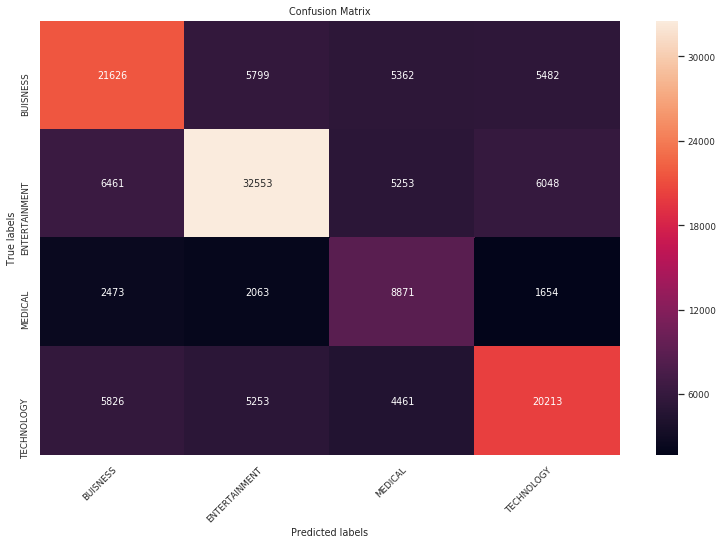

In [0]:
#https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
import seaborn as sns
import matplotlib.pyplot as plt     
ax= plt.subplot()
sns.heatmap(a, annot=True, ax = ax,fmt='g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(b);
ax.yaxis.set_ticklabels(b);
ax.set_ylim(len(a),-0.000000000000000000000000000000000000001)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor");

FROM THE ABOVE CONFUSION MATRIX the main reason for low accuraccy is the correlation among most of the words like you can refer money in all the 4 categories but because of correlation there is less accuracy.


__GENERALLY TOPIC MODELLING IS USED WHEN OUR TOPIC IS UNKNOWn AND WE hAVE TO GRoUP DOCUMENT IN FORM OF CLUSTER so it iS not A GOOD IDEA FOR CLASSIFICATION TASK.__

__LOGISTIC REGRESSION ON LDA WITH BAG OF WORDS + other features__

<h1> TOPIC MODELING </h1>

<h1>NAIVE BAYES ON BAG OF WORDS<h1>

I USED NAIVE BAYES BECAUSE OF ITS INTERPRETABLITY

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

In [0]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_bow = hstack((X_train_title_bow ,X_train_wc_norm ,X_train_vr_norm, X_train_adj_norm, X_train_adv_norm, X_train_ag_norm, X_train_nn_norm , X_train_prc_norm, X_train_cc_norm, X_train_pc_norm)).tocsr()

In [0]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_cv_bow = hstack((X_cv_title_bow ,X_cv_wc_norm ,X_cv_vr_norm, X_cv_adj_norm, X_cv_adv_norm, X_cv_ag_norm, X_cv_nn_norm , X_cv_prc_norm, X_cv_cc_norm, X_cv_pc_norm)).tocsr()

In [0]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_test_bow = hstack((X_test_title_bow ,X_test_wc_norm ,X_test_vr_norm, X_test_adj_norm, X_test_adv_norm, X_test_ag_norm, X_test_nn_norm , X_test_prc_norm, X_test_cc_norm, X_test_pc_norm)).tocsr()

In [0]:
print("Final Data matrix")
print(X_tr_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

Final Data matrix
(189622, 5009) (189622,)
(93397, 5009) (93397,)
(139398, 5009) (139398,)


__GRIDSEARCH IS USED FOR FINDING THE BEST HYPErPARAMETER__<br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [0]:
NB = MultinomialNB()
parameters = {'alpha':  [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}
classifier = GridSearchCV(NB, parameters, cv=3, scoring='accuracy',return_train_score=True)
classifier.fit(X_tr_bow, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005,
                                   0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500,
                                   1000, 2500, 5000, 10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [0]:
classifier.best_params_

{'alpha': 0.05}

In [0]:
NB=MultinomialNB(alpha=0.05)

In [0]:
NB.fit(X_tr_bow, y_train)

MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True)

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [0]:
NB.score(X_cv_bow,y_cv)

0.900050322815508

In [0]:
NB.score(X_test_bow, y_test)

0.899761833024864

In [0]:
y_test.shape

(139398,)

In [0]:
X_test_pred = NB.predict(X_test_bow)
a=confusion_matrix(y_test, X_test_pred)

In [0]:
b=list(encoder.classes_)

In [0]:
b

['BUISNESS', 'ENTERTAINMENT', 'MEDICAL', 'TECHNOLOGY']

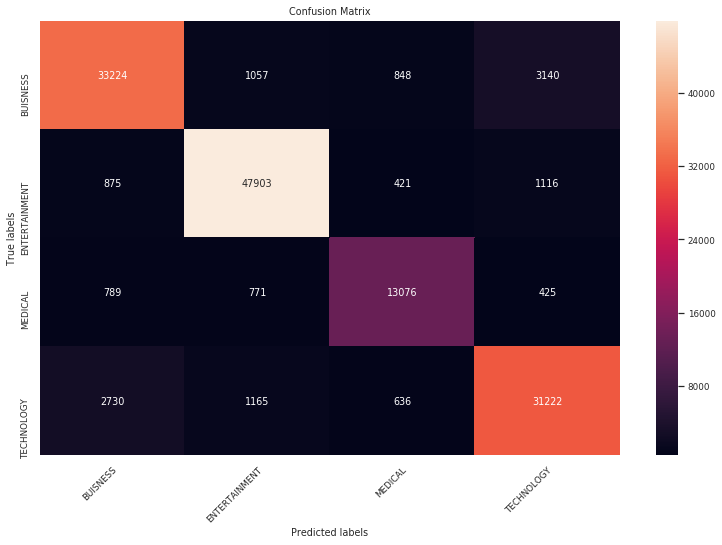

In [0]:
#https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
import seaborn as sns
import matplotlib.pyplot as plt     
ax= plt.subplot()
sns.heatmap(a, annot=True, ax = ax,fmt='g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(b);
ax.yaxis.set_ticklabels(b);
ax.set_ylim(len(a),-0.000000000000000000000000000000000000001)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor");

by seeing the above matrix few conclusion can be made as medical is the completely different category from all other category so there is very less correlation among medical and all other.
In buisness and technology more corelation is there because of the similar term.<br>
eg Mobile phones sales is increasing.



FROM THE ABOVE CONFUSION MATRIX IT CAN BE SEEN THAT MOST OF THE LABELS IS CORRECTLY CLASSIFIED

__PRECISION AND RECALL__

In [0]:
from sklearn.metrics import classification_report

In [0]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
print(classification_report(y_test, X_test_pred, target_names=encoder.classes_))

               precision    recall  f1-score   support

     BUISNESS       0.88      0.87      0.88     38269
ENTERTAINMENT       0.94      0.95      0.95     50315
      MEDICAL       0.87      0.87      0.87     15061
   TECHNOLOGY       0.87      0.87      0.87     35753

     accuracy                           0.90    139398
    macro avg       0.89      0.89      0.89    139398
 weighted avg       0.90      0.90      0.90    139398



to know about all the term of classification report<br>
http://rushdishams.blogspot.com/2011/08/micro-and-macro-average-of-precision.html

__NAIVE BAYES ON TFIDF__

In [0]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_tfidf = hstack((X_train_title_tfidf ,X_train_wc_norm ,X_train_vr_norm, X_train_adj_norm, X_train_adv_norm, X_train_ag_norm, X_train_nn_norm , X_train_prc_norm, X_train_cc_norm, X_train_pc_norm)).tocsr()

In [0]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_cv_tfidf = hstack((X_cv_title_tfidf ,X_cv_wc_norm ,X_cv_vr_norm, X_cv_adj_norm, X_cv_adv_norm, X_cv_ag_norm, X_cv_nn_norm , X_cv_prc_norm, X_cv_cc_norm, X_cv_pc_norm)).tocsr()

In [0]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_test_tfidf = hstack((X_test_title_tfidf ,X_test_wc_norm ,X_test_vr_norm, X_test_adj_norm, X_test_adv_norm, X_test_ag_norm, X_test_nn_norm , X_test_prc_norm, X_test_cc_norm, X_test_pc_norm)).tocsr()

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV


In [0]:
NB = MultinomialNB()
parameters = {'alpha':  [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}
classifier = GridSearchCV(NB, parameters, cv=3, scoring='accuracy',return_train_score=True)
classifier.fit(X_tr_tfidf, y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005,
                                   0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500,
                                   1000, 2500, 5000, 10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [0]:
classifier.best_params_

{'alpha': 0.1}

In [0]:
NB=MultinomialNB(alpha=0.1)

In [0]:
NB.fit(X_tr_tfidf, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [0]:
train_score = NB.score(X_tr_tfidf, y_train)

In [0]:
train_score

0.9368955079052008

In [0]:
NB.score(X_cv_tfidf,y_cv)

0.9246014325941947

In [0]:
NB.score(X_test_tfidf, y_test)

0.9248626235670526

In [0]:
X_test_pred = NB.predict(X_test_tfidf)
a=confusion_matrix(y_test, X_test_pred)

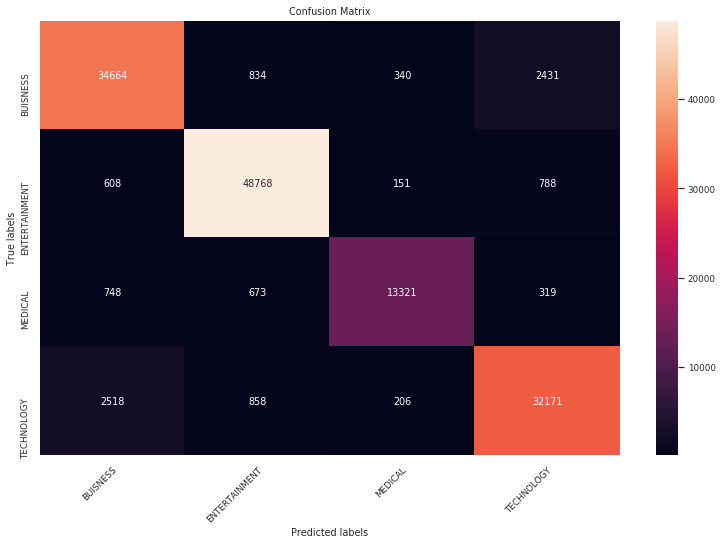

In [0]:
#https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
import seaborn as sns
import matplotlib.pyplot as plt     
ax= plt.subplot()
sns.heatmap(a, annot=True, ax = ax,fmt='g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(b);
ax.yaxis.set_ticklabels(b);
ax.set_ylim(len(a),-0.000000000000000000000000000000000000001)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor");

FROM THE ABOVE CONFUSION MATRIX IT CAN BE SEEN THAT MOST OF THE LABELS IS CORRECTLY CLASSIFIED

__PRECISION AND RECALL__

In [0]:
from sklearn.metrics import classification_report

In [0]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
print(classification_report(y_test, X_test_pred, target_names=encoder.classes_))

               precision    recall  f1-score   support

     BUISNESS       0.90      0.91      0.90     38269
ENTERTAINMENT       0.95      0.97      0.96     50315
      MEDICAL       0.95      0.88      0.92     15061
   TECHNOLOGY       0.90      0.90      0.90     35753

     accuracy                           0.92    139398
    macro avg       0.93      0.91      0.92    139398
 weighted avg       0.92      0.92      0.92    139398



<h1>SGD CLASSIFIER (loss = LOG)</h1>

__LOGISTIC REGRESSION IS FOR BINARY CLASSIFICATION PROBLEM ONLY BUT CAN USE IT FOR MULTICLASS CLASSIFICATION BY USING ONE VS REST CLASSIFICATION__

LOGISTIC REGRESSION ON BAG OF WORDS

__This estimator implements regularized linear models with stochastic gradient descent__

one vs rest<br>
https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

In [0]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier

In [0]:
param_grid  = {"estimator__alpha": [10**-5, 10**-3, 10**-1, 10**1, 10**2]}

clf = OneVsRestClassifier(SGDClassifier(loss='log',penalty='l1'))

model = GridSearchCV(clf,param_grid, scoring = 'accuracy', cv=3,n_jobs=-1)

model.fit(X_tr_bow, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001,
                                                                   average=False,
                                                                   class_weight=None,
                                                                   early_stopping=False,
                                                                   epsilon=0.1,
                                                                   eta0=0.0,
                                                                   fit_intercept=True,
                                                                   l1_ratio=0.15,
                                                                   learning_rate='optimal',
                                                                   loss='log',
                                                                   max_iter=1000,
                                               

In [0]:
model.best_params_

{'estimator__alpha': 1e-05}

In [0]:
clf = OneVsRestClassifier(SGDClassifier(loss='log',penalty='l2',alpha=0.00001,class_weight='balanced'))

In [ ]:
clf.fit(X_tr_bow,y_train)

In [0]:
score = clf.score(X_tr_bow,y_train)
print(score)

0.931263250044826


In [0]:
score = clf.score(X_cv_bow,y_cv)
print(score)

0.9169887683758579


In [0]:
score = clf.score(X_test_bow,y_test)
print(score)

0.915974404223877


b

In [0]:
X_test_pred = clf.predict(X_test_bow)
a=confusion_matrix(y_test, X_test_pred)

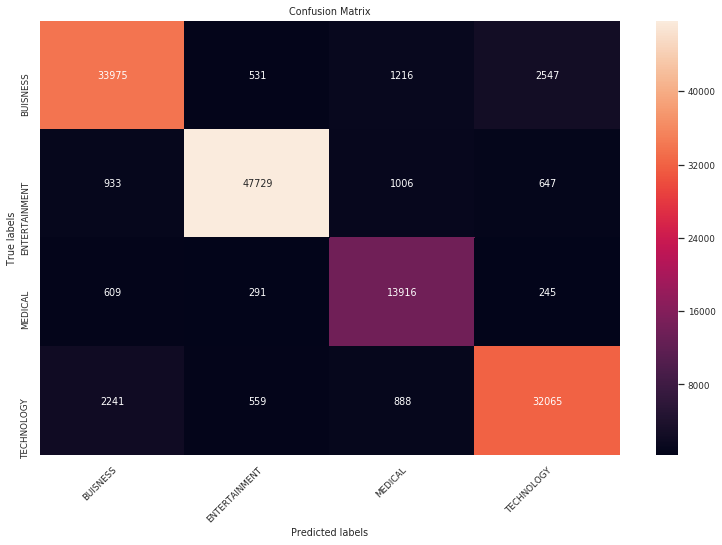

In [0]:
#https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
import seaborn as sns
import matplotlib.pyplot as plt     
ax= plt.subplot()
sns.heatmap(a, annot=True, ax = ax,fmt='g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(b);
ax.yaxis.set_ticklabels(b);
ax.set_ylim(len(a),-0.000000000000000000000000000000000000001)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor");

FROM THE ABOVE CONFUSION MATRIX IT CAN BE SEEN THAT MOST OF THE LABELS IS CORRECTLY CLASSIFIED

__PRECISION AND RECALL__

In [0]:
from sklearn.metrics import classification_report

In [0]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
print(classification_report(y_test, X_test_pred, target_names=encoder.classes_))

               precision    recall  f1-score   support

     BUISNESS       0.90      0.89      0.89     38269
ENTERTAINMENT       0.97      0.95      0.96     50315
      MEDICAL       0.82      0.92      0.87     15061
   TECHNOLOGY       0.90      0.90      0.90     35753

     accuracy                           0.92    139398
    macro avg       0.90      0.91      0.91    139398
 weighted avg       0.92      0.92      0.92    139398



__LOGISTIC REGRESSION ON TFIDF__

In [0]:
param_grid  = {"estimator__alpha": [10**-5, 10**-3, 10**-1, 10**1, 10**2]}

clf = OneVsRestClassifier(SGDClassifier(loss='log',penalty='l1'))

model = GridSearchCV(clf,param_grid, scoring = 'accuracy', cv=3,n_jobs=-1)

model.fit(X_tr_tfidf, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001,
                                                                   average=False,
                                                                   class_weight=None,
                                                                   early_stopping=False,
                                                                   epsilon=0.1,
                                                                   eta0=0.0,
                                                                   fit_intercept=True,
                                                                   l1_ratio=0.15,
                                                                   learning_rate='optimal',
                                                                   loss='log',
                                                                   max_iter=1000,
                                               

In [0]:
model.best_params_

{'estimator__alpha': 1e-05}

In [0]:
clf = OneVsRestClassifier(SGDClassifier(loss='log',penalty='l2',alpha=0.00001,class_weight='balanced'))

In [0]:
clf.fit(X_tr_tfidf,y_train)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False,
                                            class_weight='balanced',
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal', loss='log',
                                            max_iter=1000, n_iter_no_change=5,
                                            n_jobs=None, penalty='l2',
                                            power_t=0.5, random_state=None,
                                            shuffle=True, tol=0.001,
                                            validation_fraction=0.1, verbose=0,
                                            warm_start=False),
                    n_jobs=None)

In [0]:
score = clf.score(X_tr_tfidf,y_train)
print(score)

0.9454335467403572


In [0]:
score = clf.score(X_cv_tfidf,y_cv)
print(score)

0.934323372271058


In [0]:
score = clf.score(X_test_tfidf,y_test)
print(score)

0.9338799695834947


In [0]:
X_test_pred = clf.predict(X_test_tfidf)
a=confusion_matrix(y_test, X_test_pred)

In [0]:
b

['BUISNESS', 'ENTERTAINMENT', 'MEDICAL', 'TECHNOLOGY']

In [0]:
a

array([[34765,   598,   654,  2252],
       [  697, 48684,   431,   503],
       [  472,   285, 14129,   175],
       [ 1947,   670,   441, 32695]])

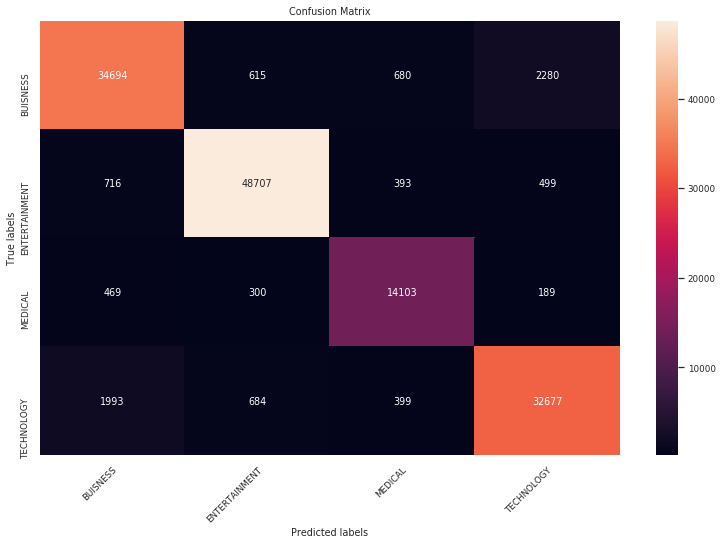

In [0]:
#https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
import seaborn as sns
import matplotlib.pyplot as plt     
ax= plt.subplot()
sns.heatmap(a, annot=True, ax = ax,fmt='g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(b);
ax.yaxis.set_ticklabels(b);
ax.set_ylim(len(a),-0.000000000000000000000000000000000000001)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor");

FROM THE ABOVE CONFUSION MATRIX IT CAN BE SEEN THAT MOST OF THE LABELS IS CORRECTLY CLASSIFIED

__PRECISION AND RECALL__

In [0]:
from sklearn.metrics import classification_report

In [0]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
print(classification_report(y_test, X_test_pred, target_names=encoder.classes_))

               precision    recall  f1-score   support

     BUISNESS       0.92      0.91      0.91     38269
ENTERTAINMENT       0.97      0.97      0.97     50315
      MEDICAL       0.91      0.94      0.92     15061
   TECHNOLOGY       0.92      0.91      0.92     35753

     accuracy                           0.93    139398
    macro avg       0.93      0.93      0.93    139398
 weighted avg       0.93      0.93      0.93    139398



In [0]:
import numpy as np


__LOGISTIC REGRESSION ON AVG W2V__

In [0]:
def loadGloveModel(gloveFile):
  print ("Loading Glove Model")
  f = open(gloveFile,'r', encoding="utf8")
  model = {}
  for line in tqdm(f):
    splitLine = line.split()
    word = splitLine[0]
    embedding = np.array([float(val) for val in splitLine[1:]])
    model[word] = embedding
  print ("Done.",len(model)," words loaded!")
  return model
model = loadGloveModel('glove.6B.300d.txt')

901it [00:00, 8999.07it/s]

Loading Glove Model


400000it [00:43, 9202.24it/s]

Done. 400000  words loaded!


In [0]:
words_train_title = []
for i in X_train['clean_titles']:
  words_train_title.extend(i.split(' '))

In [0]:
print("all the words in the corpus", len(words_train_title))


all the words in the corpus 1505474


In [0]:
words_train_title = set(words_train_title)
print("the unique words in the corpus", len(words_train_title))

the unique words in the corpus 41337


In [0]:
inter_words = set(model.keys()).intersection(words_train_title)
print("The number of words that are present in both glove vectors and our corpus are {} which \
is nearly {}% ".format(len(inter_words), np.round((float(len(inter_words))/len(words_train_title))
*100)))

The number of words that are present in both glove vectors and our corpus are 35373 which is nearly 86.0% 


In [0]:
words_corpus_train_title = {}
words_glove = set(model.keys())

In [0]:
for i in words_train_title:
  if i in words_glove:
    words_corpus_train_title[i] = model[i]
print("word 2 vec length", len(words_corpus_train_title))

word 2 vec length 35373


In [0]:
import pickle
with open('glove_vectors', 'wb') as f:
  pickle.dump(words_corpus_train_title, f)

In [0]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
  model = pickle.load(f)
  glove_words = set(model.keys())

__FOR TRAIN__

In [0]:
avg_w2v_vectors_titles_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['clean_titles']):#for each title
  vector = np.zeros(300) # as word vectors are of zero length
  cnt_words =0; # num of words with a valid vector in the sentence/review
  for word in sentence.split():# for each word in a review/sentence
    if word in glove_words:
      vector += model[word]
      cnt_words += 1
  if cnt_words != 0:
    vector /= cnt_words
  avg_w2v_vectors_titles_train.append(vector)
print('\n')
print(len(avg_w2v_vectors_titles_train))
print(len(avg_w2v_vectors_titles_train[0]))

100%|██████████| 189622/189622 [00:05<00:00, 36786.36it/s]



189622
300


In [0]:
avg_w2v_vectors_titles_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_titles']):#for each title
  vector = np.zeros(300) # as word vectors are of zero length
  cnt_words =0; # num of words with a valid vector in the sentence/review
  for word in sentence.split():# for each word in a review/sentence
    if word in glove_words:
      vector += model[word]
      cnt_words += 1
  if cnt_words != 0:
    vector /= cnt_words
  avg_w2v_vectors_titles_test.append(vector)
print('\n')
print(len(avg_w2v_vectors_titles_test))
print(len(avg_w2v_vectors_titles_test[0]))

100%|██████████| 139398/139398 [00:03<00:00, 36649.00it/s]



139398
300


__FOR CROSS VALIDATION__

In [0]:
avg_w2v_vectors_titles_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['clean_titles']):#for each title
  vector = np.zeros(300) # as word vectors are of zero length
  cnt_words =0; # num of words with a valid vector in the sentence/review
  for word in sentence.split():# for each word in a review/sentence
    if word in glove_words:
      vector += model[word]
      cnt_words += 1
  if cnt_words != 0:
    vector /= cnt_words
  avg_w2v_vectors_titles_cv.append(vector)
print('\n')
print(len(avg_w2v_vectors_titles_cv))
print(len(avg_w2v_vectors_titles_cv[0]))

100%|██████████| 93397/93397 [00:02<00:00, 37232.23it/s]



93397
300


In [0]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_avg = hstack((avg_w2v_vectors_titles_train,X_train_wc_norm ,X_train_vr_norm, X_train_adj_norm, X_train_adv_norm, X_train_ag_norm, X_train_nn_norm , X_train_prc_norm, X_train_cc_norm, X_train_pc_norm)).tocsr()

In [0]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_cv_avg = hstack((avg_w2v_vectors_titles_cv,X_cv_wc_norm ,X_cv_vr_norm, X_cv_adj_norm, X_cv_adv_norm, X_cv_ag_norm, X_cv_nn_norm , X_cv_prc_norm, X_cv_cc_norm, X_cv_pc_norm)).tocsr()

In [0]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_test_avg = hstack((avg_w2v_vectors_titles_test,X_test_wc_norm ,X_test_vr_norm, X_test_adj_norm, X_test_adv_norm, X_test_ag_norm, X_test_nn_norm , X_test_prc_norm, X_test_cc_norm, X_test_pc_norm)).tocsr()

In [0]:
param_grid  = {"estimator__alpha": [10**-5, 10**-3, 10**-1, 10**1, 10**2]}

clf = OneVsRestClassifier(SGDClassifier(loss='log',penalty='l1'))

model_1 = GridSearchCV(clf,param_grid, scoring = 'accuracy', cv=3,n_jobs=-1)

model_1.fit(X_tr_avg, y_train)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001,
                                                                   average=False,
                                                                   class_weight=None,
                                                                   early_stopping=False,
                                                                   epsilon=0.1,
                                                                   eta0=0.0,
                                                                   fit_intercept=True,
                                                                   l1_ratio=0.15,
                                                                   learning_rate='optimal',
                                                                   loss='log',
                                                                   max_iter=1000,
                               

In [0]:
model_1.best_params_

{'estimator__alpha': 1e-05}

In [0]:
clf = OneVsRestClassifier(SGDClassifier(loss='log',penalty='l2',alpha=0.00001,class_weight='balanced'))

In [0]:
clf.fit(x_tr_avg, y_train)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False,
                                            class_weight='balanced',
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal', loss='log',
                                            max_iter=1000, n_iter_no_change=5,
                                            n_jobs=None, penalty='l2',
                                            power_t=0.5, random_state=None,
                                            shuffle=True, tol=0.001,
                                            validation_fraction=0.1, verbose=0,
                                            warm_start=False),
                    n_jobs=None)

In [0]:
score = clf.score(x_tr_avg,y_train)
print(score)

0.8641349632426617


In [0]:
score = clf.score(x_cv_avg,y_cv)
print(score)

0.8598027773911368


In [0]:
score = clf.score(x_test_avg,y_test)
print(score)

0.8602562447093932


In [0]:
b=list(encoder.classes_)

In [0]:
X_test_pred = clf.predict(x_test_avg)
a=confusion_matrix(y_test, X_test_pred)

In [0]:
b

['BUISNESS', 'ENTERTAINMENT', 'MEDICAL', 'TECHNOLOGY']

In [0]:
a

array([[31540,  1329,  1165,  4235],
       [ 1517, 45788,  1132,  1878],
       [  995,   695, 12788,   583],
       [ 3533,  1565,   853, 29802]])

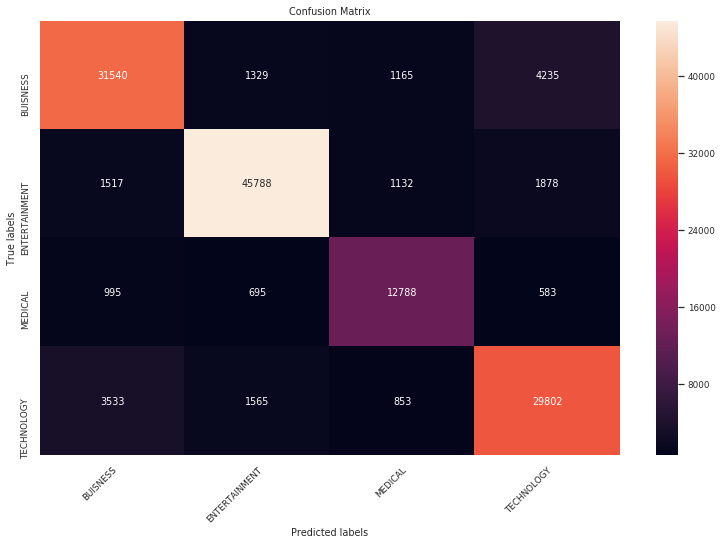

In [0]:
#https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
import seaborn as sns
import matplotlib.pyplot as plt     
ax= plt.subplot()
sns.heatmap(a, annot=True, ax = ax,fmt='g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(b);
ax.yaxis.set_ticklabels(b);
ax.set_ylim(len(a),-0.000000000000000000000000000000000000001)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor");

FROM THE ABOVE CONFUSION MATRIX IT CAN BE SEEN THAT MOST OF THE LABELS IS CORRECTLY CLASSIFIED

__PRECISION AND RECALL__

In [0]:
from sklearn.metrics import classification_report

In [0]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
print(classification_report(y_test, X_test_pred, target_names=encoder.classes_))

               precision    recall  f1-score   support

     BUISNESS       0.84      0.82      0.83     38269
ENTERTAINMENT       0.93      0.91      0.92     50315
      MEDICAL       0.80      0.85      0.83     15061
   TECHNOLOGY       0.82      0.83      0.82     35753

     accuracy                           0.86    139398
    macro avg       0.85      0.85      0.85    139398
 weighted avg       0.86      0.86      0.86    139398



__TFIDF WEIGHTED W2V__

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['clean_titles'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

__TRAIN TITLES__

In [0]:
tfidf_w2v_vectors_titles_train = []; 

for sentence in tqdm(X_train['clean_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_titles_train.append(vector)
print('\n')
print(len(tfidf_w2v_vectors_titles_train))
print(len(tfidf_w2v_vectors_titles_train[0]))

100%|██████████| 189622/189622 [00:13<00:00, 14306.34it/s]



189622
300


__TEST TITLES__ 

In [0]:
# compute average word2vec for each review.
#test titles
tfidf_w2v_vectors_titles_test = []; 

for sentence in tqdm(X_test['clean_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_titles_test.append(vector)
print('\n')
print(len(tfidf_w2v_vectors_titles_test))
print(len(tfidf_w2v_vectors_titles_test[0]))

100%|██████████| 139398/139398 [00:10<00:00, 13181.29it/s]



139398
300


__CROSS VALIDAION__

In [0]:
# compute average word2vec for each review.
#cross validation titles
tfidf_w2v_vectors_titles_cv = []; 

for sentence in tqdm(X_cv['clean_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_titles_cv.append(vector)

print(len(tfidf_w2v_vectors_titles_cv))
print(len(tfidf_w2v_vectors_titles_cv[0]))

100%|██████████| 93397/93397 [00:07<00:00, 11952.05it/s]

93397
300


In [0]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_tfidf_w2v = hstack((tfidf_w2v_vectors_titles_train ,X_train_wc_norm ,X_train_vr_norm, X_train_adj_norm, X_train_adv_norm, X_train_ag_norm, X_train_nn_norm , X_train_prc_norm, X_train_cc_norm, X_train_pc_norm)).tocsr()

In [0]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_cv_tfidf_w2v = hstack((\tfidf_w2v_vectors_titles_cv  ,X_cv_wc_norm ,X_cv_vr_norm, X_cv_adj_norm, X_cv_adv_norm, X_cv_ag_norm, X_cv_nn_norm , X_cv_prc_norm, X_cv_cc_norm, X_cv_pc_norm)).tocsr()

In [0]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_test_tfidf_w2v = hstack((tfidf_w2v_vectors_titles_test ,X_test_wc_norm ,X_test_vr_norm, X_test_adj_norm, X_test_adv_norm, X_test_ag_norm, X_test_nn_norm , X_test_prc_norm, X_test_cc_norm, X_test_pc_norm)).tocsr()

In [0]:
param_grid  = {"estimator__alpha": [10**-5, 10**-3, 10**-1, 10**1, 10**2]}

clf = OneVsRestClassifier(SGDClassifier(loss='log',penalty='l1'))

model = GridSearchCV(clf,param_grid, scoring = 'accuracy', cv=3,n_jobs=-1)

model.fit(x_tr_tfidf_w2v, y_train)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001,
                                                                   average=False,
                                                                   class_weight=None,
                                                                   early_stopping=False,
                                                                   epsilon=0.1,
                                                                   eta0=0.0,
                                                                   fit_intercept=True,
                                                                   l1_ratio=0.15,
                                                                   learning_rate='optimal',
                                                                   loss='log',
                                                                   max_iter=1000,
                               

In [0]:
model.best_params_

{'estimator__alpha': 1e-05}

In [0]:
clf = OneVsRestClassifier(SGDClassifier(loss='log',penalty='l2',alpha=0.00001,class_weight='balanced'))

In [0]:
clf.fit(x_tr_tfidf_w2v , y_train)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False,
                                            class_weight='balanced',
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal', loss='log',
                                            max_iter=1000, n_iter_no_change=5,
                                            n_jobs=None, penalty='l2',
                                            power_t=0.5, random_state=None,
                                            shuffle=True, tol=0.001,
                                            validation_fraction=0.1, verbose=0,
                                            warm_start=False),
                    n_jobs=None)

In [0]:
score = clf.score(x_tr_tfidf_w2v,y_train)
print(score)

0.8493687441330647


In [0]:
score = clf.score(X_cv_tfidf_w2v,y_cv)
print(score)

0.8459907705814962


In [0]:
score = clf.score(X_test_tfidf_w2v,y_test)
print(score)

0.8458084047116888


In [0]:
b=list(encoder.classes_)

In [0]:
X_test_pred = clf.predict(X_test_tfidf_w2v)
a=confusion_matrix(y_test, X_test_pred)

In [0]:
b

['BUISNESS', 'ENTERTAINMENT', 'MEDICAL', 'TECHNOLOGY']

In [0]:
a

array([[30276,  1783,  2224,  3986],
       [ 1099, 46003,  1726,  1487],
       [  622,   684, 13427,   328],
       [ 3685,  2089,  1781, 28198]])

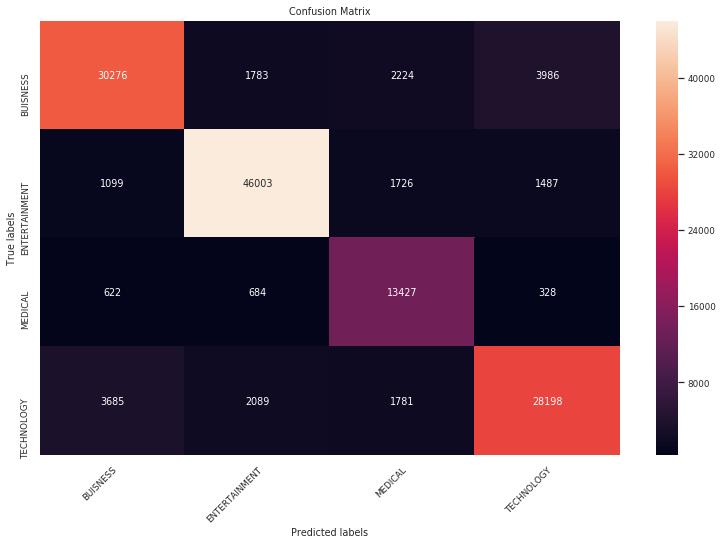

In [0]:
#https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
import seaborn as sns
import matplotlib.pyplot as plt     
ax= plt.subplot()
sns.heatmap(a, annot=True, ax = ax,fmt='g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(b);
ax.yaxis.set_ticklabels(b);
ax.set_ylim(len(a),-0.000000000000000000000000000000000000001)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor");

FROM THE ABOVE CONFUSION MATRIX IT CAN BE SEEN THAT MOST OF THE LABELS IS CORRECTLY CLASSIFIED

__PRECISION AND RECALL__

In [0]:
from sklearn.metrics import classification_report

In [0]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
print(classification_report(y_test, X_test_pred, target_names=encoder.classes_))

               precision    recall  f1-score   support

     BUISNESS       0.85      0.79      0.82     38269
ENTERTAINMENT       0.91      0.91      0.91     50315
      MEDICAL       0.70      0.89      0.78     15061
   TECHNOLOGY       0.83      0.79      0.81     35753

     accuracy                           0.85    139398
    macro avg       0.82      0.85      0.83    139398
 weighted avg       0.85      0.85      0.85    139398



<h1>LSTM</h1>

In [12]:
import numpy as np
import pandas as pd 
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


__PREPROCESSING__

In [0]:
df_data=pd.read_csv('uci-news-aggregator.csv')

In [14]:
from tqdm import tqdm
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(df_data['TITLE'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_title.append(sent.lower().strip())

100%|██████████| 422419/422419 [00:14<00:00, 29162.15it/s]


In [0]:
df_data['clean_titles']=preprocessed_title

In [0]:
data= df_data[0:300000]

In [17]:
data.CATEGORY.value_counts()

e    109792
b     81731
t     76909
m     31568
Name: CATEGORY, dtype: int64

1. Vectorize article title, by turning each text into either a sequence of integers or into a vector.
2. Limit the data set to the top 5,0000 words.
3. Set the max number of words in each article at 250.

In [18]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(data['clean_titles'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 47422 unique tokens.


__PAD SEQUENCE IS USED SO THAT EACH VECTOR IS OF SAME LENGTH__

In [19]:
X = tokenizer.texts_to_sequences(data['clean_titles'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (300000, 250)


__CONVERTING CATEgory to numerical__<br>
you can think this as label encoder

In [20]:
Y = pd.get_dummies(data['CATEGORY']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (300000, 4)


__SPLITTING THE DATA INTO TRAIN AND TEST__

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(210000, 250) (210000, 4)
(90000, 250) (90000, 4)



1. The first layer is the embedded layer that uses 100 length vectors to represent each word.
2. SpatialDropout1D performs variational dropout in NLP models.
3. The next layer is the LSTM layer with 100 memory units.
4. The output layer must create 4 output values, one for each class.
5. Activation function is softmax for multi-class classification.
6. Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

In [22]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 5,080,804
Trainable params: 5,080,804
Non-trainable params: 0
_________________________________________________________________


In [0]:
from tensorflow import keras

In [25]:
from tensorboardcolab import *
#https://github.com/taomanwai/tensorboardcolab/
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://cbfef86a.ngrok.io


In [26]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.3,callbacks=[TensorBoardColabCallback(tbc)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 147000 samples, validate on 63000 samples







Epoch 1/5
147000/147000 [==============================] - 1373s 9ms/step - loss: 0.2586 - acc: 0.9068 - val_loss: 0.1572 - val_acc: 0.9455

Epoch 2/5
147000/147000 [==============================] - 1371s 9ms/step - loss: 0.1166 - acc: 0.9594 - val_loss: 0.1558 - val_acc: 0.9460
Epoch 3/5
147000/147000 [==============================] - 1375s 9ms/step - loss: 0.0885 - acc: 0.9686 - val_loss: 0.1617 - val_acc: 0.9458
Epoch 4/5
147000/147000 [==============================] - 1382s 9ms/step - loss: 0.0687 - acc: 0.9757 - val_loss: 0.1754 - val_acc: 0.9448
Epoch 5/5
147000/147000 [==============================] - 1356s 9ms/step - loss: 0.0562 - acc: 0.9792 - val_loss: 0.1918 - val_acc: 0.9447


In [0]:
%tensorboard --logdir logs/gradient_tape2

In [27]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: 0.9501'.format(accr[0],accr[1]))

90000/90000 [==============================] - 518s 6ms/step
Test set
  Loss: 0.199
  Accuracy: 0.9501


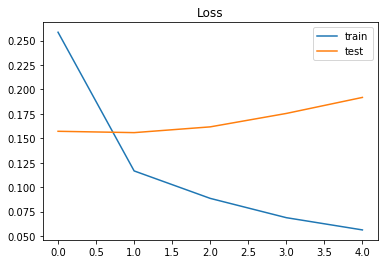

In [29]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

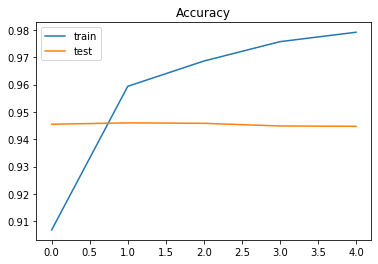

In [30]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [0]:
def check(new_title):
  seq = tokenizer.texts_to_sequences(new_title)
  padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
  pred = model.predict(padded)
  labels=['b','e','m','t']
  print(pred)
  print('\n')
  Dict = {'b': 'buisness', 'm': 'Medical', 'e': 'Entertainment','t': 'technology'}
  return (Dict[labels[np.argmax(pred)]])

__lets check some of the category for perfomane of model__

In [33]:
title=['Private hospitals threaten to stop CGHS, ECHS cashless services']
check(title)

[[0.0154025  0.03887397 0.9444972  0.0012263 ]]




'Medical'

In [34]:
title=['5G for all Xiaomi flagship smartphones in 2020: Will Redmi K30 Pro bring 5G phones to India?']
check(title)

[[1.8441373e-05 8.9668983e-06 2.7788301e-06 9.9996984e-01]]




'technology'

<h1>BERT(Bidirectional Encoder Representations from Transformers)</h1>

If you’ve been following Natural Language Processing over the past year, you’ve probably heard of BERT: Bidirectional Encoder Representations from Transformers. It’s a neural network architecture designed by Google researchers that’s totally transformed what’s state-of-the-art for NLP tasks, like text classification, translation, summarization, and question answering.

Now that BERT's been added to [TF Hub](https://www.tensorflow.org/hub) as a loadable module, it's easy(ish) to add into existing Tensorflow text pipelines. In an existing pipeline, BERT can replace text embedding layers like ELMO and GloVE. Alternatively, [finetuning](http://wiki.fast.ai/index.php/Fine_tuning) BERT can provide both an accuracy boost and faster training time in many cases.

Here, we'll train a model to predict the category of news using BERT in Tensorflow with tf hub. Some code was adapted from [this colab notebook](https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb). Let's get started!

__Reference__
#https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb

In [0]:
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 3.2MB/s 


In [0]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
from bert import modeling

In [0]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from sklearn.model_selection import train_test_split
import os
print("tensorflow version : ", tf.__version__)
print("tensorflow_hub version : ", hub.__version__)

tensorflow version :  1.15.0
tensorflow_hub version :  0.7.0


In [0]:
data['clean_titles'] = preprocessed_title

In [0]:
data.drop(['TITLE'],inplace=True,axis = 1 )

In [0]:
data.head()

,CATEGORY,clean_titles
0,b,fed official says weak data caused weather not...
1,b,fed charles plosser sees high bar change pace ...
2,b,us open stocks fall fed official hints acceler...
3,b,fed risks falling behind curve charles plosser...
4,b,fed plosser nasty weather has curbed job growth


<h2>There are four distinct sections where each story may fall in to</h2>

1. Politics<br>
2. Technology<br>
3. Entertainment<br>
4. Business</h2>

In [0]:
train, val =  train_test_split(data, test_size = 0.3, random_state = 100)

In [0]:
train.shape

(295693, 2)

In [0]:
val.shape

(126726, 2)

__DATA PREPROCESSING__

BERT model accept only a specific type of input and the datasets are usually structured to have have the following four features:<br>

guid : A unique id that represents an observation.<br>

text_a : The text we need to classify into given categories<br>

text_b: It is used when we're training a model to understand the<br> 
relationship between sentences and it does not apply for classification problems.<br>

label: It consists of the labels or classes or categories that a given text belongs to.<br>


In our dataset we have text_a and label. The following code block will <br>
create objects for each of the above mentioned features for all the records <br>
in our dataset using the InputExample class provided in the BERT library.

In [0]:
train['CATEGORY']

111124    e
194324    e
233355    m
175484    e
279407    e
         ..
339799    t
253799    e
210755    e
56088     m
300552    m
Name: CATEGORY, Length: 295693, dtype: object

In [0]:
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x['clean_titles'], 
                                                                   text_b = None, 
                                                                   label = x['CATEGORY']), axis = 1)

val_InputExamples = val.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x['clean_titles'], 
                                                                   text_b = None, 
                                                                   label = x['CATEGORY']), axis = 1)

In [0]:
train_InputExamples

111124    <bert.run_classifier.InputExample object at 0x...
194324    <bert.run_classifier.InputExample object at 0x...
233355    <bert.run_classifier.InputExample object at 0x...
175484    <bert.run_classifier.InputExample object at 0x...
279407    <bert.run_classifier.InputExample object at 0x...
                                ...                        
339799    <bert.run_classifier.InputExample object at 0x...
253799    <bert.run_classifier.InputExample object at 0x...
210755    <bert.run_classifier.InputExample object at 0x...
56088     <bert.run_classifier.InputExample object at 0x...
300552    <bert.run_classifier.InputExample object at 0x...
Length: 295693, dtype: object

In [0]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  easter videos inspire change new beginnings

__________
Row 0 - text_b of training set :  None

__________
Row 0 - label of training set :  e


We will now get down to business with the pretrained BERT. In this example we will use the bert_uncased_L-12_H-768_A-12/1 model. To check all available versions click here.

We will be using the vocab.txt file in the model to map the words in the dataset to indexes. Also the loaded BERT model is trained on uncased/lowercase data and hence the data we feed to train the model should also be of lowercase.(so we preprocess the data earlier)



The following code block loads the pre-trained BERT model and initializers a tokenizer object for tokenizing the texts.

In [0]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['easter', 'videos', 'inspire', 'change', 'new', 'beginnings']


In [0]:
train['CATEGORY'].unique()

array(['e', 'm', 'b', 't'], dtype=object)

In [0]:
label_list = ['e','m','b','t']

In [0]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128

# Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 295693


INFO:tensorflow:Writing example 0 of 295693


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] easter videos inspire change new beginnings [SEP]


INFO:tensorflow:tokens: [CLS] easter videos inspire change new beginnings [SEP]


INFO:tensorflow:input_ids: 101 10957 6876 18708 2689 2047 16508 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 10957 6876 18708 2689 2047 16508 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: e (id = 0)


INFO:tensorflow:label: e (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] caesar rises dawn planet apes full theatrical trailer [SEP]


INFO:tensorflow:tokens: [CLS] caesar rises dawn planet apes full theatrical trailer [SEP]


INFO:tensorflow:input_ids: 101 11604 9466 6440 4774 27754 2440 8900 9117 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 11604 9466 6440 4774 27754 2440 8900 9117 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: e (id = 0)


INFO:tensorflow:label: e (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] mer ##s co ##v dentistry [SEP]


INFO:tensorflow:tokens: [CLS] mer ##s co ##v dentistry [SEP]


INFO:tensorflow:input_ids: 101 21442 2015 2522 2615 26556 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 21442 2015 2522 2615 26556 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: m (id = 1)


INFO:tensorflow:label: m (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] return original cast ham ##ill ford fisher strike back star wars vii [SEP]


INFO:tensorflow:tokens: [CLS] return original cast ham ##ill ford fisher strike back star wars vii [SEP]


INFO:tensorflow:input_ids: 101 2709 2434 3459 10654 8591 4811 8731 4894 2067 2732 5233 8890 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2709 2434 3459 10654 8591 4811 8731 4894 2067 2732 5233 8890 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: e (id = 0)


INFO:tensorflow:label: e (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] wal ##mart truck driver plead ##s not guilty tracy morgan crash [SEP]


INFO:tensorflow:tokens: [CLS] wal ##mart truck driver plead ##s not guilty tracy morgan crash [SEP]


INFO:tensorflow:input_ids: 101 24547 22345 4744 4062 25803 2015 2025 5905 10555 5253 5823 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 24547 22345 4744 4062 25803 2015 2025 5905 10555 5253 5823 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: e (id = 0)


INFO:tensorflow:label: e (id = 0)


INFO:tensorflow:Writing example 10000 of 295693


INFO:tensorflow:Writing example 10000 of 295693


INFO:tensorflow:Writing example 20000 of 295693


INFO:tensorflow:Writing example 20000 of 295693


INFO:tensorflow:Writing example 30000 of 295693


INFO:tensorflow:Writing example 30000 of 295693


INFO:tensorflow:Writing example 40000 of 295693


INFO:tensorflow:Writing example 40000 of 295693


INFO:tensorflow:Writing example 50000 of 295693


INFO:tensorflow:Writing example 50000 of 295693


INFO:tensorflow:Writing example 60000 of 295693


INFO:tensorflow:Writing example 60000 of 295693


INFO:tensorflow:Writing example 70000 of 295693


INFO:tensorflow:Writing example 70000 of 295693


INFO:tensorflow:Writing example 80000 of 295693


INFO:tensorflow:Writing example 80000 of 295693


INFO:tensorflow:Writing example 90000 of 295693


INFO:tensorflow:Writing example 90000 of 295693


INFO:tensorflow:Writing example 100000 of 295693


INFO:tensorflow:Writing example 100000 of 295693


INFO:tensorflow:Writing example 110000 of 295693


INFO:tensorflow:Writing example 110000 of 295693


INFO:tensorflow:Writing example 120000 of 295693


INFO:tensorflow:Writing example 120000 of 295693


INFO:tensorflow:Writing example 130000 of 295693


INFO:tensorflow:Writing example 130000 of 295693


INFO:tensorflow:Writing example 140000 of 295693


INFO:tensorflow:Writing example 140000 of 295693


INFO:tensorflow:Writing example 150000 of 295693


INFO:tensorflow:Writing example 150000 of 295693


INFO:tensorflow:Writing example 160000 of 295693


INFO:tensorflow:Writing example 160000 of 295693


INFO:tensorflow:Writing example 170000 of 295693


INFO:tensorflow:Writing example 170000 of 295693


INFO:tensorflow:Writing example 180000 of 295693


INFO:tensorflow:Writing example 180000 of 295693


INFO:tensorflow:Writing example 190000 of 295693


INFO:tensorflow:Writing example 190000 of 295693


INFO:tensorflow:Writing example 200000 of 295693


INFO:tensorflow:Writing example 200000 of 295693


INFO:tensorflow:Writing example 210000 of 295693


INFO:tensorflow:Writing example 210000 of 295693


INFO:tensorflow:Writing example 220000 of 295693


INFO:tensorflow:Writing example 220000 of 295693


INFO:tensorflow:Writing example 230000 of 295693


INFO:tensorflow:Writing example 230000 of 295693


INFO:tensorflow:Writing example 240000 of 295693


INFO:tensorflow:Writing example 240000 of 295693


INFO:tensorflow:Writing example 250000 of 295693


INFO:tensorflow:Writing example 250000 of 295693


INFO:tensorflow:Writing example 260000 of 295693


INFO:tensorflow:Writing example 260000 of 295693


INFO:tensorflow:Writing example 270000 of 295693


INFO:tensorflow:Writing example 270000 of 295693


INFO:tensorflow:Writing example 280000 of 295693


INFO:tensorflow:Writing example 280000 of 295693


INFO:tensorflow:Writing example 290000 of 295693


INFO:tensorflow:Writing example 290000 of 295693


INFO:tensorflow:Writing example 0 of 126726


INFO:tensorflow:Writing example 0 of 126726


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] sony expects playstation 4 bring profits ps ##2 [SEP]


INFO:tensorflow:tokens: [CLS] sony expects playstation 4 bring profits ps ##2 [SEP]


INFO:tensorflow:input_ids: 101 8412 24273 9160 1018 3288 11372 8827 2475 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 8412 24273 9160 1018 3288 11372 8827 2475 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: b (id = 2)


INFO:tensorflow:label: b (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] res ##vera ##tro ##l red wine does not boost longevity health [SEP]


INFO:tensorflow:tokens: [CLS] res ##vera ##tro ##l red wine does not boost longevity health [SEP]


INFO:tensorflow:input_ids: 101 24501 26061 13181 2140 2417 4511 2515 2025 12992 26906 2740 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 24501 26061 13181 2140 2417 4511 2515 2025 12992 26906 2740 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: m (id = 1)


INFO:tensorflow:label: m (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] iraq may dent not der ##ail market rally [SEP]


INFO:tensorflow:tokens: [CLS] iraq may dent not der ##ail market rally [SEP]


INFO:tensorflow:input_ids: 101 5712 2089 21418 2025 4315 12502 3006 8320 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 5712 2089 21418 2025 4315 12502 3006 8320 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: b (id = 2)


INFO:tensorflow:label: b (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] spielberg next two movies scheduled 2015 2016 openings [SEP]


INFO:tensorflow:tokens: [CLS] spielberg next two movies scheduled 2015 2016 openings [SEP]


INFO:tensorflow:input_ids: 101 28740 2279 2048 5691 5115 2325 2355 16556 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 28740 2279 2048 5691 5115 2325 2355 16556 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: e (id = 0)


INFO:tensorflow:label: e (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] wall street flat ahead housing data chicago pm ##i mann ##kind surge ##s [SEP]


INFO:tensorflow:tokens: [CLS] wall street flat ahead housing data chicago pm ##i mann ##kind surge ##s [SEP]


INFO:tensorflow:input_ids: 101 2813 2395 4257 3805 3847 2951 3190 7610 2072 10856 18824 12058 2015 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2813 2395 4257 3805 3847 2951 3190 7610 2072 10856 18824 12058 2015 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: m (id = 1)


INFO:tensorflow:label: m (id = 1)


INFO:tensorflow:Writing example 10000 of 126726


INFO:tensorflow:Writing example 10000 of 126726


INFO:tensorflow:Writing example 20000 of 126726


INFO:tensorflow:Writing example 20000 of 126726


INFO:tensorflow:Writing example 30000 of 126726


INFO:tensorflow:Writing example 30000 of 126726


INFO:tensorflow:Writing example 40000 of 126726


INFO:tensorflow:Writing example 40000 of 126726


INFO:tensorflow:Writing example 50000 of 126726


INFO:tensorflow:Writing example 50000 of 126726


INFO:tensorflow:Writing example 60000 of 126726


INFO:tensorflow:Writing example 60000 of 126726


INFO:tensorflow:Writing example 70000 of 126726


INFO:tensorflow:Writing example 70000 of 126726


INFO:tensorflow:Writing example 80000 of 126726


INFO:tensorflow:Writing example 80000 of 126726


INFO:tensorflow:Writing example 90000 of 126726


INFO:tensorflow:Writing example 90000 of 126726


INFO:tensorflow:Writing example 100000 of 126726


INFO:tensorflow:Writing example 100000 of 126726


INFO:tensorflow:Writing example 110000 of 126726


INFO:tensorflow:Writing example 110000 of 126726


INFO:tensorflow:Writing example 120000 of 126726


INFO:tensorflow:Writing example 120000 of 126726


In [0]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [0]:
#A function that adapts our model to work for training, evaluation, and prediction.

# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [0]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)


In [0]:
num_train_steps

27721

In [0]:
num_train_steps = 10000

In [0]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpjfpgd5ve', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd1579949b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpjfpgd5ve', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd1579949b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [0]:
num_train_steps = 10000

In [0]:
#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpjfpgd5ve/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpjfpgd5ve/model.ckpt.


INFO:tensorflow:loss = 1.4400151, step = 0


INFO:tensorflow:loss = 1.4400151, step = 0


INFO:tensorflow:global_step/sec: 1.54525


INFO:tensorflow:global_step/sec: 1.54525


INFO:tensorflow:loss = 1.2718576, step = 100 (64.716 sec)


INFO:tensorflow:loss = 1.2718576, step = 100 (64.716 sec)


INFO:tensorflow:global_step/sec: 2.09449


INFO:tensorflow:global_step/sec: 2.09449


INFO:tensorflow:loss = 0.779948, step = 200 (47.745 sec)


INFO:tensorflow:loss = 0.779948, step = 200 (47.745 sec)


INFO:tensorflow:global_step/sec: 2.09419


INFO:tensorflow:global_step/sec: 2.09419


INFO:tensorflow:loss = 0.5050781, step = 300 (47.751 sec)


INFO:tensorflow:loss = 0.5050781, step = 300 (47.751 sec)


INFO:tensorflow:global_step/sec: 2.09468


INFO:tensorflow:global_step/sec: 2.09468


INFO:tensorflow:loss = 0.4653861, step = 400 (47.740 sec)


INFO:tensorflow:loss = 0.4653861, step = 400 (47.740 sec)


INFO:tensorflow:global_step/sec: 2.09515


INFO:tensorflow:global_step/sec: 2.09515


INFO:tensorflow:loss = 0.3484096, step = 500 (47.729 sec)


INFO:tensorflow:loss = 0.3484096, step = 500 (47.729 sec)


INFO:tensorflow:global_step/sec: 2.09407


INFO:tensorflow:global_step/sec: 2.09407


INFO:tensorflow:loss = 0.42845732, step = 600 (47.754 sec)


INFO:tensorflow:loss = 0.42845732, step = 600 (47.754 sec)


INFO:tensorflow:global_step/sec: 2.09547


INFO:tensorflow:global_step/sec: 2.09547


INFO:tensorflow:loss = 0.31938827, step = 700 (47.722 sec)


INFO:tensorflow:loss = 0.31938827, step = 700 (47.722 sec)


INFO:tensorflow:global_step/sec: 2.0967


INFO:tensorflow:global_step/sec: 2.0967


INFO:tensorflow:loss = 0.20143284, step = 800 (47.694 sec)


INFO:tensorflow:loss = 0.20143284, step = 800 (47.694 sec)


INFO:tensorflow:global_step/sec: 2.09652


INFO:tensorflow:global_step/sec: 2.09652


INFO:tensorflow:loss = 0.25443953, step = 900 (47.697 sec)


INFO:tensorflow:loss = 0.25443953, step = 900 (47.697 sec)


INFO:tensorflow:global_step/sec: 2.09548


INFO:tensorflow:global_step/sec: 2.09548


INFO:tensorflow:loss = 0.4756101, step = 1000 (47.724 sec)


INFO:tensorflow:loss = 0.4756101, step = 1000 (47.724 sec)


INFO:tensorflow:global_step/sec: 2.09567


INFO:tensorflow:global_step/sec: 2.09567


INFO:tensorflow:loss = 0.25338012, step = 1100 (47.715 sec)


INFO:tensorflow:loss = 0.25338012, step = 1100 (47.715 sec)


INFO:tensorflow:Saving checkpoints for 1193 into /tmp/tmpjfpgd5ve/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1193 into /tmp/tmpjfpgd5ve/model.ckpt.


INFO:tensorflow:global_step/sec: 1.75963


INFO:tensorflow:global_step/sec: 1.75963


INFO:tensorflow:loss = 0.3506614, step = 1200 (56.830 sec)


INFO:tensorflow:loss = 0.3506614, step = 1200 (56.830 sec)


INFO:tensorflow:global_step/sec: 2.09556


INFO:tensorflow:global_step/sec: 2.09556


INFO:tensorflow:loss = 0.16091193, step = 1300 (47.720 sec)


INFO:tensorflow:loss = 0.16091193, step = 1300 (47.720 sec)


INFO:tensorflow:global_step/sec: 2.09582


INFO:tensorflow:global_step/sec: 2.09582


INFO:tensorflow:loss = 0.28520793, step = 1400 (47.714 sec)


INFO:tensorflow:loss = 0.28520793, step = 1400 (47.714 sec)


INFO:tensorflow:global_step/sec: 2.09533


INFO:tensorflow:global_step/sec: 2.09533


INFO:tensorflow:loss = 0.2541682, step = 1500 (47.725 sec)


INFO:tensorflow:loss = 0.2541682, step = 1500 (47.725 sec)


INFO:tensorflow:global_step/sec: 2.09644


INFO:tensorflow:global_step/sec: 2.09644


INFO:tensorflow:loss = 0.1637952, step = 1600 (47.700 sec)


INFO:tensorflow:loss = 0.1637952, step = 1600 (47.700 sec)


INFO:tensorflow:global_step/sec: 2.0956


INFO:tensorflow:global_step/sec: 2.0956


INFO:tensorflow:loss = 0.123194836, step = 1700 (47.719 sec)


INFO:tensorflow:loss = 0.123194836, step = 1700 (47.719 sec)


INFO:tensorflow:global_step/sec: 2.09559


INFO:tensorflow:global_step/sec: 2.09559


INFO:tensorflow:loss = 0.25009882, step = 1800 (47.719 sec)


INFO:tensorflow:loss = 0.25009882, step = 1800 (47.719 sec)


INFO:tensorflow:global_step/sec: 2.09466


INFO:tensorflow:global_step/sec: 2.09466


INFO:tensorflow:loss = 0.22107045, step = 1900 (47.740 sec)


INFO:tensorflow:loss = 0.22107045, step = 1900 (47.740 sec)


INFO:tensorflow:global_step/sec: 2.09632


INFO:tensorflow:global_step/sec: 2.09632


INFO:tensorflow:loss = 0.116031334, step = 2000 (47.702 sec)


INFO:tensorflow:loss = 0.116031334, step = 2000 (47.702 sec)


INFO:tensorflow:global_step/sec: 2.09496


INFO:tensorflow:global_step/sec: 2.09496


INFO:tensorflow:loss = 0.08446592, step = 2100 (47.735 sec)


INFO:tensorflow:loss = 0.08446592, step = 2100 (47.735 sec)


INFO:tensorflow:global_step/sec: 2.0944


INFO:tensorflow:global_step/sec: 2.0944


INFO:tensorflow:loss = 0.32245556, step = 2200 (47.745 sec)


INFO:tensorflow:loss = 0.32245556, step = 2200 (47.745 sec)


INFO:tensorflow:global_step/sec: 2.09409


INFO:tensorflow:global_step/sec: 2.09409


INFO:tensorflow:loss = 0.12078181, step = 2300 (47.753 sec)


INFO:tensorflow:loss = 0.12078181, step = 2300 (47.753 sec)


INFO:tensorflow:global_step/sec: 2.095


INFO:tensorflow:global_step/sec: 2.095


INFO:tensorflow:loss = 0.18872747, step = 2400 (47.735 sec)


INFO:tensorflow:loss = 0.18872747, step = 2400 (47.735 sec)


INFO:tensorflow:Saving checkpoints for 2432 into /tmp/tmpjfpgd5ve/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2432 into /tmp/tmpjfpgd5ve/model.ckpt.


INFO:tensorflow:global_step/sec: 1.79321


INFO:tensorflow:global_step/sec: 1.79321


INFO:tensorflow:loss = 0.4338733, step = 2500 (55.763 sec)


INFO:tensorflow:loss = 0.4338733, step = 2500 (55.763 sec)


INFO:tensorflow:global_step/sec: 2.09357


INFO:tensorflow:global_step/sec: 2.09357


INFO:tensorflow:loss = 0.17657511, step = 2600 (47.765 sec)


INFO:tensorflow:loss = 0.17657511, step = 2600 (47.765 sec)


INFO:tensorflow:global_step/sec: 2.0936


INFO:tensorflow:global_step/sec: 2.0936


INFO:tensorflow:loss = 0.27626926, step = 2700 (47.765 sec)


INFO:tensorflow:loss = 0.27626926, step = 2700 (47.765 sec)


INFO:tensorflow:global_step/sec: 2.09388


INFO:tensorflow:global_step/sec: 2.09388


INFO:tensorflow:loss = 0.18429472, step = 2800 (47.758 sec)


INFO:tensorflow:loss = 0.18429472, step = 2800 (47.758 sec)


INFO:tensorflow:global_step/sec: 2.0937


INFO:tensorflow:global_step/sec: 2.0937


INFO:tensorflow:loss = 0.08747085, step = 2900 (47.762 sec)


INFO:tensorflow:loss = 0.08747085, step = 2900 (47.762 sec)


INFO:tensorflow:global_step/sec: 2.09523


INFO:tensorflow:global_step/sec: 2.09523


INFO:tensorflow:loss = 0.11639917, step = 3000 (47.730 sec)


INFO:tensorflow:loss = 0.11639917, step = 3000 (47.730 sec)


INFO:tensorflow:global_step/sec: 2.0938


INFO:tensorflow:global_step/sec: 2.0938


INFO:tensorflow:loss = 0.42775127, step = 3100 (47.757 sec)


INFO:tensorflow:loss = 0.42775127, step = 3100 (47.757 sec)


INFO:tensorflow:global_step/sec: 2.0944


INFO:tensorflow:global_step/sec: 2.0944


INFO:tensorflow:loss = 0.11641002, step = 3200 (47.747 sec)


INFO:tensorflow:loss = 0.11641002, step = 3200 (47.747 sec)


INFO:tensorflow:global_step/sec: 2.09501


INFO:tensorflow:global_step/sec: 2.09501


INFO:tensorflow:loss = 0.101047516, step = 3300 (47.732 sec)


INFO:tensorflow:loss = 0.101047516, step = 3300 (47.732 sec)


INFO:tensorflow:global_step/sec: 2.09478


INFO:tensorflow:global_step/sec: 2.09478


INFO:tensorflow:loss = 0.20013097, step = 3400 (47.738 sec)


INFO:tensorflow:loss = 0.20013097, step = 3400 (47.738 sec)


INFO:tensorflow:global_step/sec: 2.09494


INFO:tensorflow:global_step/sec: 2.09494


INFO:tensorflow:loss = 0.32637954, step = 3500 (47.734 sec)


INFO:tensorflow:loss = 0.32637954, step = 3500 (47.734 sec)


INFO:tensorflow:global_step/sec: 2.09372


INFO:tensorflow:global_step/sec: 2.09372


INFO:tensorflow:loss = 0.098416984, step = 3600 (47.761 sec)


INFO:tensorflow:loss = 0.098416984, step = 3600 (47.761 sec)


INFO:tensorflow:Saving checkpoints for 3672 into /tmp/tmpjfpgd5ve/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3672 into /tmp/tmpjfpgd5ve/model.ckpt.


INFO:tensorflow:global_step/sec: 1.79421


INFO:tensorflow:global_step/sec: 1.79421


INFO:tensorflow:loss = 0.13979399, step = 3700 (55.737 sec)


INFO:tensorflow:loss = 0.13979399, step = 3700 (55.737 sec)


INFO:tensorflow:global_step/sec: 2.09432


INFO:tensorflow:global_step/sec: 2.09432


INFO:tensorflow:loss = 0.114718795, step = 3800 (47.747 sec)


INFO:tensorflow:loss = 0.114718795, step = 3800 (47.747 sec)


INFO:tensorflow:global_step/sec: 2.094


INFO:tensorflow:global_step/sec: 2.094


INFO:tensorflow:loss = 0.18959312, step = 3900 (47.755 sec)


INFO:tensorflow:loss = 0.18959312, step = 3900 (47.755 sec)


INFO:tensorflow:global_step/sec: 2.09406


INFO:tensorflow:global_step/sec: 2.09406


INFO:tensorflow:loss = 0.25920454, step = 4000 (47.754 sec)


INFO:tensorflow:loss = 0.25920454, step = 4000 (47.754 sec)


INFO:tensorflow:global_step/sec: 2.09389


INFO:tensorflow:global_step/sec: 2.09389


INFO:tensorflow:loss = 0.13839471, step = 4100 (47.759 sec)


INFO:tensorflow:loss = 0.13839471, step = 4100 (47.759 sec)


INFO:tensorflow:global_step/sec: 2.09493


INFO:tensorflow:global_step/sec: 2.09493


INFO:tensorflow:loss = 0.12544863, step = 4200 (47.734 sec)


INFO:tensorflow:loss = 0.12544863, step = 4200 (47.734 sec)


INFO:tensorflow:global_step/sec: 2.09501


INFO:tensorflow:global_step/sec: 2.09501


INFO:tensorflow:loss = 0.20015565, step = 4300 (47.733 sec)


INFO:tensorflow:loss = 0.20015565, step = 4300 (47.733 sec)


INFO:tensorflow:global_step/sec: 2.09349


INFO:tensorflow:global_step/sec: 2.09349


INFO:tensorflow:loss = 0.41222495, step = 4400 (47.766 sec)


INFO:tensorflow:loss = 0.41222495, step = 4400 (47.766 sec)


INFO:tensorflow:global_step/sec: 2.09325


INFO:tensorflow:global_step/sec: 2.09325


INFO:tensorflow:loss = 0.25870934, step = 4500 (47.772 sec)


INFO:tensorflow:loss = 0.25870934, step = 4500 (47.772 sec)


INFO:tensorflow:global_step/sec: 2.09401


INFO:tensorflow:global_step/sec: 2.09401


INFO:tensorflow:loss = 0.022922518, step = 4600 (47.755 sec)


INFO:tensorflow:loss = 0.022922518, step = 4600 (47.755 sec)


INFO:tensorflow:global_step/sec: 2.09524


INFO:tensorflow:global_step/sec: 2.09524


INFO:tensorflow:loss = 0.46393624, step = 4700 (47.727 sec)


INFO:tensorflow:loss = 0.46393624, step = 4700 (47.727 sec)


INFO:tensorflow:global_step/sec: 2.09327


INFO:tensorflow:global_step/sec: 2.09327


INFO:tensorflow:loss = 0.1013532, step = 4800 (47.772 sec)


INFO:tensorflow:loss = 0.1013532, step = 4800 (47.772 sec)


INFO:tensorflow:global_step/sec: 2.09371


INFO:tensorflow:global_step/sec: 2.09371


INFO:tensorflow:loss = 0.25663513, step = 4900 (47.763 sec)


INFO:tensorflow:loss = 0.25663513, step = 4900 (47.763 sec)


INFO:tensorflow:Saving checkpoints for 4912 into /tmp/tmpjfpgd5ve/model.ckpt.


INFO:tensorflow:Saving checkpoints for 4912 into /tmp/tmpjfpgd5ve/model.ckpt.


INFO:tensorflow:global_step/sec: 1.79268


INFO:tensorflow:global_step/sec: 1.79268


INFO:tensorflow:loss = 0.28752893, step = 5000 (55.782 sec)


INFO:tensorflow:loss = 0.28752893, step = 5000 (55.782 sec)


INFO:tensorflow:global_step/sec: 2.09431


INFO:tensorflow:global_step/sec: 2.09431


INFO:tensorflow:loss = 0.10549684, step = 5100 (47.748 sec)


INFO:tensorflow:loss = 0.10549684, step = 5100 (47.748 sec)


INFO:tensorflow:global_step/sec: 2.09433


INFO:tensorflow:global_step/sec: 2.09433


INFO:tensorflow:loss = 0.11223653, step = 5200 (47.748 sec)


INFO:tensorflow:loss = 0.11223653, step = 5200 (47.748 sec)


INFO:tensorflow:global_step/sec: 2.0948


INFO:tensorflow:global_step/sec: 2.0948


INFO:tensorflow:loss = 0.016594458, step = 5300 (47.737 sec)


INFO:tensorflow:loss = 0.016594458, step = 5300 (47.737 sec)


INFO:tensorflow:global_step/sec: 2.09416


INFO:tensorflow:global_step/sec: 2.09416


INFO:tensorflow:loss = 0.12704207, step = 5400 (47.752 sec)


INFO:tensorflow:loss = 0.12704207, step = 5400 (47.752 sec)


INFO:tensorflow:global_step/sec: 2.09477


INFO:tensorflow:global_step/sec: 2.09477


INFO:tensorflow:loss = 0.32793927, step = 5500 (47.739 sec)


INFO:tensorflow:loss = 0.32793927, step = 5500 (47.739 sec)


INFO:tensorflow:global_step/sec: 2.09418


INFO:tensorflow:global_step/sec: 2.09418


INFO:tensorflow:loss = 0.032255817, step = 5600 (47.751 sec)


INFO:tensorflow:loss = 0.032255817, step = 5600 (47.751 sec)


INFO:tensorflow:global_step/sec: 2.09351


INFO:tensorflow:global_step/sec: 2.09351


INFO:tensorflow:loss = 0.027657615, step = 5700 (47.766 sec)


INFO:tensorflow:loss = 0.027657615, step = 5700 (47.766 sec)


INFO:tensorflow:global_step/sec: 2.09249


INFO:tensorflow:global_step/sec: 2.09249


INFO:tensorflow:loss = 0.009712063, step = 5800 (47.790 sec)


INFO:tensorflow:loss = 0.009712063, step = 5800 (47.790 sec)


INFO:tensorflow:global_step/sec: 2.09398


INFO:tensorflow:global_step/sec: 2.09398


INFO:tensorflow:loss = 0.051923983, step = 5900 (47.756 sec)


INFO:tensorflow:loss = 0.051923983, step = 5900 (47.756 sec)


INFO:tensorflow:global_step/sec: 2.09366


INFO:tensorflow:global_step/sec: 2.09366


INFO:tensorflow:loss = 0.20909604, step = 6000 (47.764 sec)


INFO:tensorflow:loss = 0.20909604, step = 6000 (47.764 sec)


INFO:tensorflow:global_step/sec: 2.09504


INFO:tensorflow:global_step/sec: 2.09504


INFO:tensorflow:loss = 0.0562156, step = 6100 (47.731 sec)


INFO:tensorflow:loss = 0.0562156, step = 6100 (47.731 sec)


INFO:tensorflow:Saving checkpoints for 6152 into /tmp/tmpjfpgd5ve/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6152 into /tmp/tmpjfpgd5ve/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:global_step/sec: 1.78915


INFO:tensorflow:global_step/sec: 1.78915


INFO:tensorflow:loss = 0.20135406, step = 6200 (55.893 sec)


INFO:tensorflow:loss = 0.20135406, step = 6200 (55.893 sec)


INFO:tensorflow:global_step/sec: 2.09419


INFO:tensorflow:global_step/sec: 2.09419


INFO:tensorflow:loss = 0.25333044, step = 6300 (47.751 sec)


INFO:tensorflow:loss = 0.25333044, step = 6300 (47.751 sec)


INFO:tensorflow:global_step/sec: 2.09333


INFO:tensorflow:global_step/sec: 2.09333


INFO:tensorflow:loss = 0.016249444, step = 6400 (47.771 sec)


INFO:tensorflow:loss = 0.016249444, step = 6400 (47.771 sec)


INFO:tensorflow:global_step/sec: 2.09543


INFO:tensorflow:global_step/sec: 2.09543


INFO:tensorflow:loss = 0.05500251, step = 6500 (47.723 sec)


INFO:tensorflow:loss = 0.05500251, step = 6500 (47.723 sec)


INFO:tensorflow:global_step/sec: 2.09581


INFO:tensorflow:global_step/sec: 2.09581


INFO:tensorflow:loss = 0.018381195, step = 6600 (47.714 sec)


INFO:tensorflow:loss = 0.018381195, step = 6600 (47.714 sec)


INFO:tensorflow:global_step/sec: 2.09449


INFO:tensorflow:global_step/sec: 2.09449


INFO:tensorflow:loss = 0.13874683, step = 6700 (47.744 sec)


INFO:tensorflow:loss = 0.13874683, step = 6700 (47.744 sec)


INFO:tensorflow:global_step/sec: 2.09421


INFO:tensorflow:global_step/sec: 2.09421


INFO:tensorflow:loss = 0.509861, step = 6800 (47.754 sec)


INFO:tensorflow:loss = 0.509861, step = 6800 (47.754 sec)


INFO:tensorflow:global_step/sec: 2.09369


INFO:tensorflow:global_step/sec: 2.09369


INFO:tensorflow:loss = 0.16380075, step = 6900 (47.759 sec)


INFO:tensorflow:loss = 0.16380075, step = 6900 (47.759 sec)


INFO:tensorflow:global_step/sec: 2.09395


INFO:tensorflow:global_step/sec: 2.09395


INFO:tensorflow:loss = 0.2483741, step = 7000 (47.759 sec)


INFO:tensorflow:loss = 0.2483741, step = 7000 (47.759 sec)


INFO:tensorflow:global_step/sec: 2.0955


INFO:tensorflow:global_step/sec: 2.0955


INFO:tensorflow:loss = 0.044744037, step = 7100 (47.720 sec)


INFO:tensorflow:loss = 0.044744037, step = 7100 (47.720 sec)


INFO:tensorflow:global_step/sec: 2.09566


INFO:tensorflow:global_step/sec: 2.09566


INFO:tensorflow:loss = 0.08703435, step = 7200 (47.718 sec)


INFO:tensorflow:loss = 0.08703435, step = 7200 (47.718 sec)


INFO:tensorflow:global_step/sec: 2.09465


INFO:tensorflow:global_step/sec: 2.09465


INFO:tensorflow:loss = 0.2315301, step = 7300 (47.740 sec)


INFO:tensorflow:loss = 0.2315301, step = 7300 (47.740 sec)


INFO:tensorflow:Saving checkpoints for 7392 into /tmp/tmpjfpgd5ve/model.ckpt.


INFO:tensorflow:Saving checkpoints for 7392 into /tmp/tmpjfpgd5ve/model.ckpt.


INFO:tensorflow:global_step/sec: 1.78982


INFO:tensorflow:global_step/sec: 1.78982


INFO:tensorflow:loss = 0.028157374, step = 7400 (55.872 sec)


INFO:tensorflow:loss = 0.028157374, step = 7400 (55.872 sec)


INFO:tensorflow:global_step/sec: 2.09321


INFO:tensorflow:global_step/sec: 2.09321


INFO:tensorflow:loss = 0.21097548, step = 7500 (47.774 sec)


INFO:tensorflow:loss = 0.21097548, step = 7500 (47.774 sec)


INFO:tensorflow:global_step/sec: 2.09355


INFO:tensorflow:global_step/sec: 2.09355


INFO:tensorflow:loss = 0.17518708, step = 7600 (47.765 sec)


INFO:tensorflow:loss = 0.17518708, step = 7600 (47.765 sec)


INFO:tensorflow:global_step/sec: 2.09284


INFO:tensorflow:global_step/sec: 2.09284


INFO:tensorflow:loss = 0.07676031, step = 7700 (47.782 sec)


INFO:tensorflow:loss = 0.07676031, step = 7700 (47.782 sec)


INFO:tensorflow:global_step/sec: 2.09353


INFO:tensorflow:global_step/sec: 2.09353


INFO:tensorflow:loss = 0.1563174, step = 7800 (47.766 sec)


INFO:tensorflow:loss = 0.1563174, step = 7800 (47.766 sec)


INFO:tensorflow:global_step/sec: 2.09406


INFO:tensorflow:global_step/sec: 2.09406


INFO:tensorflow:loss = 0.29015365, step = 7900 (47.757 sec)


INFO:tensorflow:loss = 0.29015365, step = 7900 (47.757 sec)


INFO:tensorflow:global_step/sec: 2.09256


INFO:tensorflow:global_step/sec: 2.09256


INFO:tensorflow:loss = 0.25762174, step = 8000 (47.785 sec)


INFO:tensorflow:loss = 0.25762174, step = 8000 (47.785 sec)


INFO:tensorflow:global_step/sec: 2.09506


INFO:tensorflow:global_step/sec: 2.09506


INFO:tensorflow:loss = 0.258339, step = 8100 (47.731 sec)


INFO:tensorflow:loss = 0.258339, step = 8100 (47.731 sec)


INFO:tensorflow:global_step/sec: 2.09353


INFO:tensorflow:global_step/sec: 2.09353


INFO:tensorflow:loss = 0.097313106, step = 8200 (47.766 sec)


INFO:tensorflow:loss = 0.097313106, step = 8200 (47.766 sec)


INFO:tensorflow:global_step/sec: 2.09239


INFO:tensorflow:global_step/sec: 2.09239


INFO:tensorflow:loss = 0.14850414, step = 8300 (47.792 sec)


INFO:tensorflow:loss = 0.14850414, step = 8300 (47.792 sec)


INFO:tensorflow:global_step/sec: 2.09355


INFO:tensorflow:global_step/sec: 2.09355


INFO:tensorflow:loss = 0.15720896, step = 8400 (47.766 sec)


INFO:tensorflow:loss = 0.15720896, step = 8400 (47.766 sec)


INFO:tensorflow:global_step/sec: 2.09357


INFO:tensorflow:global_step/sec: 2.09357


INFO:tensorflow:loss = 0.050404865, step = 8500 (47.765 sec)


INFO:tensorflow:loss = 0.050404865, step = 8500 (47.765 sec)


INFO:tensorflow:global_step/sec: 2.09401


INFO:tensorflow:global_step/sec: 2.09401


INFO:tensorflow:loss = 0.032789566, step = 8600 (47.754 sec)


INFO:tensorflow:loss = 0.032789566, step = 8600 (47.754 sec)


INFO:tensorflow:Saving checkpoints for 8632 into /tmp/tmpjfpgd5ve/model.ckpt.


INFO:tensorflow:Saving checkpoints for 8632 into /tmp/tmpjfpgd5ve/model.ckpt.


INFO:tensorflow:global_step/sec: 1.79311


INFO:tensorflow:global_step/sec: 1.79311


INFO:tensorflow:loss = 0.17508322, step = 8700 (55.769 sec)


INFO:tensorflow:loss = 0.17508322, step = 8700 (55.769 sec)


INFO:tensorflow:global_step/sec: 2.09475


INFO:tensorflow:global_step/sec: 2.09475


INFO:tensorflow:loss = 0.13299263, step = 8800 (47.739 sec)


INFO:tensorflow:loss = 0.13299263, step = 8800 (47.739 sec)


INFO:tensorflow:global_step/sec: 2.09412


INFO:tensorflow:global_step/sec: 2.09412


INFO:tensorflow:loss = 0.07210097, step = 8900 (47.752 sec)


INFO:tensorflow:loss = 0.07210097, step = 8900 (47.752 sec)


INFO:tensorflow:global_step/sec: 2.09375


INFO:tensorflow:global_step/sec: 2.09375


INFO:tensorflow:loss = 0.0069385646, step = 9000 (47.761 sec)


INFO:tensorflow:loss = 0.0069385646, step = 9000 (47.761 sec)


INFO:tensorflow:global_step/sec: 2.09327


INFO:tensorflow:global_step/sec: 2.09327


INFO:tensorflow:loss = 0.069677606, step = 9100 (47.773 sec)


INFO:tensorflow:loss = 0.069677606, step = 9100 (47.773 sec)


INFO:tensorflow:global_step/sec: 2.09396


INFO:tensorflow:global_step/sec: 2.09396


INFO:tensorflow:loss = 0.1734121, step = 9200 (47.756 sec)


INFO:tensorflow:loss = 0.1734121, step = 9200 (47.756 sec)


INFO:tensorflow:global_step/sec: 2.09267


INFO:tensorflow:global_step/sec: 2.09267


INFO:tensorflow:loss = 0.1754842, step = 9300 (47.786 sec)


INFO:tensorflow:loss = 0.1754842, step = 9300 (47.786 sec)


INFO:tensorflow:global_step/sec: 2.09284


INFO:tensorflow:global_step/sec: 2.09284


INFO:tensorflow:loss = 0.04502965, step = 9400 (47.782 sec)


INFO:tensorflow:loss = 0.04502965, step = 9400 (47.782 sec)


INFO:tensorflow:global_step/sec: 2.09333


INFO:tensorflow:global_step/sec: 2.09333


INFO:tensorflow:loss = 0.09996374, step = 9500 (47.771 sec)


INFO:tensorflow:loss = 0.09996374, step = 9500 (47.771 sec)


INFO:tensorflow:global_step/sec: 2.09294


INFO:tensorflow:global_step/sec: 2.09294


INFO:tensorflow:loss = 0.07429486, step = 9600 (47.780 sec)


INFO:tensorflow:loss = 0.07429486, step = 9600 (47.780 sec)


INFO:tensorflow:global_step/sec: 2.09274


INFO:tensorflow:global_step/sec: 2.09274


INFO:tensorflow:loss = 0.14950034, step = 9700 (47.784 sec)


INFO:tensorflow:loss = 0.14950034, step = 9700 (47.784 sec)


INFO:tensorflow:global_step/sec: 2.09493


INFO:tensorflow:global_step/sec: 2.09493


INFO:tensorflow:loss = 0.18433551, step = 9800 (47.735 sec)


INFO:tensorflow:loss = 0.18433551, step = 9800 (47.735 sec)


INFO:tensorflow:Saving checkpoints for 9872 into /tmp/tmpjfpgd5ve/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9872 into /tmp/tmpjfpgd5ve/model.ckpt.


INFO:tensorflow:global_step/sec: 1.78774


INFO:tensorflow:global_step/sec: 1.78774


INFO:tensorflow:loss = 0.018995669, step = 9900 (55.937 sec)


INFO:tensorflow:loss = 0.018995669, step = 9900 (55.937 sec)


INFO:tensorflow:Saving checkpoints for 10000 into /tmp/tmpjfpgd5ve/model.ckpt.


INFO:tensorflow:Saving checkpoints for 10000 into /tmp/tmpjfpgd5ve/model.ckpt.


INFO:tensorflow:Loss for final step: 0.22140136.


INFO:tensorflow:Loss for final step: 0.22140136.


Training took time  1:26:12.494960


In [0]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-15T17:44:22Z


INFO:tensorflow:Starting evaluation at 2020-02-15T17:44:22Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpjfpgd5ve/model.ckpt-10000


INFO:tensorflow:Restoring parameters from /tmp/tmpjfpgd5ve/model.ckpt-10000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-15-17:54:43


INFO:tensorflow:Finished evaluation at 2020-02-15-17:54:43


INFO:tensorflow:Saving dict for global step 10000: eval_accuracy = 0.9569938, false_negatives = 959.0, false_positives = 888.0, global_step = 10000, loss = 0.12994207, true_negatives = 45061.0, true_positives = 79818.0


INFO:tensorflow:Saving dict for global step 10000: eval_accuracy = 0.9569938, false_negatives = 959.0, false_positives = 888.0, global_step = 10000, loss = 0.12994207, true_negatives = 45061.0, true_positives = 79818.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10000: /tmp/tmpjfpgd5ve/model.ckpt-10000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10000: /tmp/tmpjfpgd5ve/model.ckpt-10000


{'eval_accuracy': 0.9569938,
 'false_negatives': 959.0,
 'false_positives': 888.0,
 'global_step': 10000,
 'loss': 0.12994207,
 'true_negatives': 45061.0,
 'true_positives': 79818.0}

In [0]:
"""Entertainment: e
Medical : m
Buisness: b
Technology: t"""

# A method to get predictions
def getPrediction(in_sentences):
  #A list to map the actual labels to the predictions
  labels = ["Entertainment", "Medical","Buisness","Technology"]

  #Transforming the test data into BERT accepted form
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 'e') for x in in_sentences] 
  
  #Creating input features for Test data
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'],prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [0]:
#Classifying random sentences
tests = getPrediction(['RBI board recommends aligning accounting year with fiscal year from 2020-21',
                       'Karan Johar asks Ranveer Singh and Ayushmann Khurrana about their fashion choices in latest video',
                       'Study shows link between fast food intake and weight gain in preschoolers',
                       'Member News: Internet Society Chapters Focus on Security'
                       ])

INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] rbi board recommends align ##ing accounting year with fiscal year from 2020 - 21 [SEP]


INFO:tensorflow:tokens: [CLS] rbi board recommends align ##ing accounting year with fiscal year from 2020 - 21 [SEP]


INFO:tensorflow:input_ids: 101 16929 2604 26021 25705 2075 9529 2095 2007 10807 2095 2013 12609 1011 2538 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 16929 2604 26021 25705 2075 9529 2095 2007 10807 2095 2013 12609 1011 2538 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: e (id = 0)


INFO:tensorflow:label: e (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] kara ##n jo ##har asks ran ##ve ##er singh and a ##yu ##sh ##mann k ##hur ##rana about their fashion choices in latest video [SEP]


INFO:tensorflow:tokens: [CLS] kara ##n jo ##har asks ran ##ve ##er singh and a ##yu ##sh ##mann k ##hur ##rana about their fashion choices in latest video [SEP]


INFO:tensorflow:input_ids: 101 13173 2078 8183 8167 5176 2743 3726 2121 5960 1998 1037 10513 4095 5804 1047 24572 16737 2055 2037 4827 9804 1999 6745 2678 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 13173 2078 8183 8167 5176 2743 3726 2121 5960 1998 1037 10513 4095 5804 1047 24572 16737 2055 2037 4827 9804 1999 6745 2678 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: e (id = 0)


INFO:tensorflow:label: e (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] study shows link between fast food intake and weight gain in preschool ##ers [SEP]


INFO:tensorflow:tokens: [CLS] study shows link between fast food intake and weight gain in preschool ##ers [SEP]


INFO:tensorflow:input_ids: 101 2817 3065 4957 2090 3435 2833 13822 1998 3635 5114 1999 23655 2545 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2817 3065 4957 2090 3435 2833 13822 1998 3635 5114 1999 23655 2545 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: e (id = 0)


INFO:tensorflow:label: e (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] member news : internet society chapters focus on security [SEP]


INFO:tensorflow:tokens: [CLS] member news : internet society chapters focus on security [SEP]


INFO:tensorflow:input_ids: 101 2266 2739 1024 4274 2554 9159 3579 2006 3036 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2266 2739 1024 4274 2554 9159 3579 2006 3036 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: e (id = 0)


INFO:tensorflow:label: e (id = 0)


***********************************************************************************
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpjfpgd5ve/model.ckpt-10000


INFO:tensorflow:Restoring parameters from /tmp/tmpjfpgd5ve/model.ckpt-10000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [0]:
tests

[('RBI board recommends aligning accounting year with fiscal year from 2020-21',
  array([-8.1830654e+00, -7.2500296e+00, -2.4898024e-03, -6.5041518e+00],
        dtype=float32),
  2,
  'Buisness'),
 ('Karan Johar asks Ranveer Singh and Ayushmann Khurrana about their fashion choices in latest video',
  array([-0.03966016, -6.5964036 , -3.690382  , -4.377533  ], dtype=float32),
  0,
  'Entertainment'),
 ('Study shows link between fast food intake and weight gain in preschoolers',
  array([-7.5647035e+00, -2.6692259e-03, -6.8908787e+00, -6.7853451e+00],
        dtype=float32),
  1,
  'Medical'),
 ('Member News: Internet Society Chapters Focus on Security',
  array([-6.2954473e+00, -6.9092121e+00, -6.8552237e+00, -3.9048151e-03],
        dtype=float32),
  3,
  'Technology')]

In [6]:
!pip install prettytable

pyautogui 0.9.48 requires mouseinfo, which is not installed.
pyautogui 0.9.48 requires pygetwindow>=0.0.5, which is not installed.
distributed 1.21.8 requires msgpack, which is not installed.
tensorflow 1.12.0 has requirement protobuf>=3.6.1, but you'll have protobuf 3.6.0 which is incompatible.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [7]:
from prettytable import PrettyTable
x = PrettyTable()
x.title = "NAIVE BAYES"
x.field_names = ["MODEL", "ACCURACY_CV", "ACCURACY_TEST"]

x.add_row(["NAIVE BAYES BOW",0.8970,0.8988])
x.add_row(["NAIVE BAYES TFIDF",0.9231,0.9236])
x.add_row(["LOGIStIC REGRESSION ON BOW",0.9164,0.9173])
x.add_row(["LOGISTIC REGRESSION ON TFIDF",0.933745,0.9329])
x.add_row(["LOGISTIC REGRESSION ON AVG_w2V",0.8598,0.86025])
x.add_row(["LOGISTIC REGRESSION ON TFIDF_W2V",0.8459,0.84580])
x.add_row(["TOPIC MODELING(LATENT DIRICHLET ALLOCATION) ",0.6046,0.6077])
x.add_row(["LSTM",0.95,0.948])
x.add_row(["BERT",0.95,0.96])



print(x)

+----------------------------------------------+-------------+---------------+
|                    MODEL                     | ACCURACY_CV | ACCURACY_TEST |
+----------------------------------------------+-------------+---------------+
|               NAIVE BAYES BOW                |    0.897    |     0.8988    |
|              NAIVE BAYES TFIDF               |    0.9231   |     0.9236    |
|          LOGIStIC REGRESSION ON BOW          |    0.9164   |     0.9173    |
|         LOGISTIC REGRESSION ON TFIDF         |   0.933745  |     0.9329    |
|        LOGISTIC REGRESSION ON AVG_w2V        |    0.8598   |    0.86025    |
|       LOGISTIC REGRESSION ON TFIDF_W2V       |    0.8459   |     0.8458    |
| TOPIC MODELING(LATENT DIRICHLET ALLOCATION)  |    0.6046   |     0.6077    |
|                     LSTM                     |     0.95    |     0.948     |
|                     BERT                     |     0.95    |      0.96     |
+----------------------------------------------+----

__the most interesting observation is this dataset is of 2014 but it gives me great result on latest news__

__SUMMARY__
1. first I load the news data which has four category.
2. main task is to classify the news category based on the title.
3. then I perform exploratory data analysis to visualize the data.
4. plot the word cloud for knowing the words which is used .
5. then I perform preprocessing of data to use it for prediction.
6. I take two models naive bayes and logistic regression for prediction.
7. at last make the pretty table to visualize the result.

__CONCLUSION__

1. BERT give me the best accuraccy and it is more interpretable
2. as you can see the category can be more because correlation between words is more.